# Heart failure: prediction of the readmission of a patient within 6 months after hospital discharge

Heart failure is a common reason for hospitalization in the elderly and it is associated with significant mortality and morbidity. \\
The data consist of a retrospective heart failure dataset created by using electronic
health data collected from patients who were admitted to a hospital in Sichuan, China between 2016 and 2019. \\
The dataset includes 168 variables for 2,008 patients with heart failure. \\

The objective of the following study is **to predict the readmission of patients at 6 months after hospital discharge**.

##Librairies import

In [1]:
# Data processing

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import pickle
from scipy.stats import zscore

# Models

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.utils import shuffle

In [2]:
# Connection to google drive

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
from os import path
path_folder = '/content/drive/MyDrive/SLHD_Project/'
path = path.join(path_folder,'dat.csv')

##Data import and target visualization


In [37]:
data = pd.read_csv(path, index_col=0)

In [ ]:
data.head()

,inpatient.number,DestinationDischarge,admission.ward,admission.way,occupation,discharge.department,visit.times,gender,body.temperature,pulse,...,body.temperature.blood.gas,oxygen.saturation,partial.oxygen.pressure,oxyhemoglobin,anion.gap,free.calcium,total.hemoglobin,GCS,dischargeDay,ageCat
1,857781,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Male,36.7,87,...,37.0,97.0,93.0,95.9,17.8,1.14,125.0,15,11,"(69,79]"
2,743087,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Female,36.8,95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,8,"(69,79]"
3,866418,Home,Cardiology,NonEmergency,farmer,Cardiology,2,Male,36.5,98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,5,"(59,69]"
4,775928,Home,Cardiology,Emergency,UrbanResident,Cardiology,1,Male,36.0,73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,11,"(69,79]"
5,810128,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Female,35.0,88,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,5,"(69,79]"


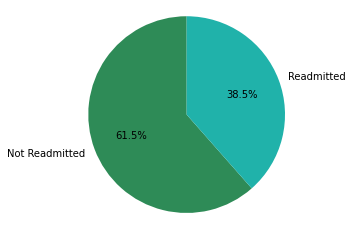

In [49]:
labels = 'Not Readmitted', 'Readmitted'
colors = ['seagreen', 'lightseagreen']

plt.pie(data['re.admission.within.6.months'].value_counts(), labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()

In [ ]:
column_to_move = data.pop('re.admission.within.6.months')
data.insert(165, 're.admission.within.6.months', column_to_move)

data.head()

,inpatient.number,DestinationDischarge,admission.ward,admission.way,occupation,discharge.department,visit.times,gender,body.temperature,pulse,...,oxygen.saturation,partial.oxygen.pressure,oxyhemoglobin,anion.gap,free.calcium,total.hemoglobin,GCS,dischargeDay,ageCat,re.admission.within.6.months
1,857781,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Male,36.7,87,...,97.0,93.0,95.9,17.8,1.14,125.0,15,11,"(69,79]",0
2,743087,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Female,36.8,95,...,NaN,NaN,NaN,NaN,NaN,NaN,15,8,"(69,79]",0
3,866418,Home,Cardiology,NonEmergency,farmer,Cardiology,2,Male,36.5,98,...,NaN,NaN,NaN,NaN,NaN,NaN,15,5,"(59,69]",0
4,775928,Home,Cardiology,Emergency,UrbanResident,Cardiology,1,Male,36.0,73,...,NaN,NaN,NaN,NaN,NaN,NaN,15,11,"(69,79]",1
5,810128,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Female,35.0,88,...,NaN,NaN,NaN,NaN,NaN,NaN,15,5,"(69,79]",0


##Check duplicates and remove useless variables/observations

In [ ]:
data[data.duplicated()] # No duplicates 

,inpatient.number,DestinationDischarge,admission.ward,admission.way,occupation,discharge.department,visit.times,gender,body.temperature,pulse,...,oxygen.saturation,partial.oxygen.pressure,oxyhemoglobin,anion.gap,free.calcium,total.hemoglobin,GCS,dischargeDay,ageCat,re.admission.within.6.months


In [ ]:
# Check if a patient is present twice or more in the dataset
len(data['inpatient.number'].unique())

# There are 2008 unique patient IDs over 2008 patients, therefore each patient is present only once in the dataset

2008

In [ ]:
# Remove inpatient.number column since it is not useful to predict the readmission of the patient
data.drop(["inpatient.number"], axis=1, inplace=True)

In [ ]:
# Move the target column at the end of the dataset
column_to_move = data.pop('re.admission.within.6.months')
data.insert(164, 're.admission.within.6.months', column_to_move)

data.head()

,DestinationDischarge,admission.ward,admission.way,occupation,discharge.department,visit.times,gender,body.temperature,pulse,respiration,...,oxygen.saturation,partial.oxygen.pressure,oxyhemoglobin,anion.gap,free.calcium,total.hemoglobin,GCS,dischargeDay,ageCat,re.admission.within.6.months
1,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Male,36.7,87,19,...,97.0,93.0,95.9,17.8,1.14,125.0,15,11,"(69,79]",0
2,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Female,36.8,95,18,...,NaN,NaN,NaN,NaN,NaN,NaN,15,8,"(69,79]",0
3,Home,Cardiology,NonEmergency,farmer,Cardiology,2,Male,36.5,98,18,...,NaN,NaN,NaN,NaN,NaN,NaN,15,5,"(59,69]",0
4,Home,Cardiology,Emergency,UrbanResident,Cardiology,1,Male,36.0,73,19,...,NaN,NaN,NaN,NaN,NaN,NaN,15,11,"(69,79]",1
5,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Female,35.0,88,19,...,NaN,NaN,NaN,NaN,NaN,NaN,15,5,"(69,79]",0


In [ ]:
# Some variables are retrospective variables, we should remove them
retrospective_variables = ['death.within.28.days', 're.admission.within.28.days', 'death.within.3.months',
                           're.admission.within.3.months', 'death.within.6.months', 'time.of.death..days.from.admission.',
                           're.admission.time..days.from.admission.', 'return.to.emergency.department.within.6.months',
                           'time.to.emergency.department.within.6.months']
              
data.drop(retrospective_variables, axis=1, inplace=True)

In [ ]:
data['DestinationDischarge'].value_counts()
# 14 patients died during their hospitalization, we should remove them from the dataset

Home                  1344
HealthcareFacility     438
Unknown                212
Died                    14
Name: DestinationDischarge, dtype: int64

In [ ]:
data = data.loc[data['DestinationDischarge'] != 'Died']
data['DestinationDischarge'].value_counts()

Home                  1344
HealthcareFacility     438
Unknown                212
Name: DestinationDischarge, dtype: int64

In [ ]:
data['outcome.during.hospitalization'].value_counts()
# Some patients died after the decision of discharge was made, we should remove them as well

Alive                    1885
DischargeAgainstOrder     107
Dead                        2
Name: outcome.during.hospitalization, dtype: int64

In [ ]:
data = data.loc[data['outcome.during.hospitalization'] != 'Dead']
data['outcome.during.hospitalization'].value_counts()

Alive                    1885
DischargeAgainstOrder     107
Name: outcome.during.hospitalization, dtype: int64

##First missing data investigation

We first would like to investigate the presence of NaNs in the dataset, to potentially exclude variables presenting a too high rate of missing values. 

In [ ]:
# (data.isnull().sum(axis = 0) == data.isna().sum(axis = 0)).value_counts()

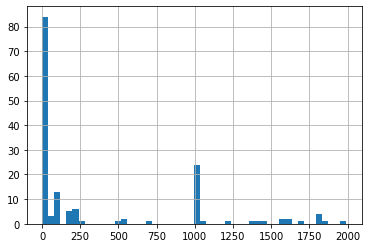

In [ ]:
data.isnull().sum(axis = 0).hist(bins=50)

This histogram shows that a lot of variables present an important amount of NaN. It would be tricky to impute those values when the rate is too high. We decide to take as a cut-off 10% of the observations, meaning that we will remove variables having more than 200 NaNs.

In [ ]:
from scipy.stats.stats import variation

def get_variables_high_nb_NaN(dataframe, threshold):
  ''' Get the variable having a nb of NaN above the threshold '''

  count_NaN = dataframe.isnull().sum(axis = 0)
  variables_high_nb_NaN = dataframe.columns[count_NaN >= threshold]

  return variables_high_nb_NaN

columns_to_drop = get_variables_high_nb_NaN(data, 200)

print(columns_to_drop)
print('\n There are {} variables in the dataset having more than 200 NaNs.'.format(len(columns_to_drop)))

Index(['LVEF', 'left.ventricular.end.diastolic.diameter.LV',
       'mitral.valve.EMS', 'mitral.valve.AMS', 'EA',
       'tricuspid.valve.return.velocity', 'tricuspid.valve.return.pressure',
       'myoglobin', 'Inorganic.Phosphorus', 'serum.magnesium',
       'creatine.kinase.isoenzyme.to.creatine.kinase',
       'hydroxybutyrate.dehydrogenase.to.lactate.dehydrogenase',
       'hydroxybutyrate.dehydrogenase', 'glutamic.oxaloacetic.transaminase',
       'creatine.kinase', 'creatine.kinase.isoenzyme', 'lactate.dehydrogenase',
       'high.sensitivity.protein', 'nucleotidase', 'fucosidase',
       'cholinesterase', 'glutamic.oxaliplatin', 'total.bile.acid',
       'erythrocyte.sedimentation.rate', 'homocysteine', 'apolipoprotein.A',
       'apolipoprotein.B', 'lipoprotein', 'pH', 'standard.residual.base',
       'standard.bicarbonate', 'partial.pressure.of.carbon.dioxide',
       'total.carbon.dioxide', 'methemoglobin', 'hematocrit.blood.gas',
       'reduced.hemoglobin', 'potassium.ion'

In [ ]:
data.drop(columns_to_drop, axis=1, inplace=True)

In [ ]:
data.head()

,DestinationDischarge,admission.ward,admission.way,occupation,discharge.department,visit.times,gender,body.temperature,pulse,respiration,...,total.bilirubin,total.protein,cholesterol,low.density.lipoprotein.cholesterol,triglyceride,high.density.lipoprotein.cholesterol,GCS,dischargeDay,ageCat,re.admission.within.6.months
1,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Male,36.7,87,19,...,18.3,61.9,3.46,1.90,2.69,0.84,15,11,"(69,79]",0
2,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Female,36.8,95,18,...,18.3,66.1,3.15,1.26,0.84,1.30,15,8,"(69,79]",0
3,Home,Cardiology,NonEmergency,farmer,Cardiology,2,Male,36.5,98,18,...,11.9,60.8,3.79,2.13,1.53,0.94,15,5,"(59,69]",0
4,Home,Cardiology,Emergency,UrbanResident,Cardiology,1,Male,36.0,73,19,...,51.6,67.1,2.92,1.31,0.92,0.98,15,11,"(69,79]",1
5,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Female,35.0,88,19,...,11.8,71.9,2.68,1.21,0.62,0.91,15,5,"(69,79]",0


In [ ]:
columns_having_NaN = data.columns[data.isnull().sum(axis = 0) > 0]

print('There are still {} variables presenting at least 1 NaN.'.format(len(columns_having_NaN)))

There are still 60 variables presenting at least 1 NaN.


60 variables still have at least 1 NaN, we will deal with them later on in the data pre-processing phase.

In [ ]:
# # NaN investigation by patient
# data.isnull().sum(axis = 1).hist(bins=50, figsize=(15,10))

# np.sum([data.isnull().sum(axis = 1) > 45])

## Split categorical/numerical variables

To better visualize and pre-process the data, let's first split the dataset into two parts: one containing all the numerical variables, and the other one gathering all the categorical variables.

In [ ]:
variables_dtype_object = data.select_dtypes(include=['object']).columns
variables_dtype_np_number = data.select_dtypes(include=[np.number]).columns

In [ ]:
# Lists of the variables having a np.number datatype but being categorical variables
# Variables under 10 unique values are defined as categoric ones
list_int_categ = ['myocardial.infarction', 'congestive.heart.failure', 'peripheral.vascular.disease', 'cerebrovascular.disease', 'dementia', 'Chronic.obstructive.pulmonary.disease', 'connective.tissue.disease', 'diabetes', 'hemiplegia', 'leukemia', 'malignant.lymphoma', 'solid.tumor', 'AIDS', 'eye.opening', 'verbal.response', 'movement', 'acute.renal.failure', 're.admission.within.6.months']
list_float_categ = ['peptic.ulcer.disease', 'moderate.to.severe.chronic.kidney.disease', 'liver.disease']

In [ ]:
# Let's look at the CCI score
data['CCI.score'].value_counts()

# We decide to keep that variable as numerical since all categories are not represented in the dataset
# Indeed, the CCI score may reach 37 at max

1.0    767
2.0    695
3.0    363
4.0     91
0.0     55
5.0     15
6.0      1
Name: CCI.score, dtype: int64

In [ ]:
# Define categorical variables and numerical variables

categorical_variables = list(variables_dtype_object) + list_int_categ + list_float_categ

numerical_variables = list(variables_dtype_np_number)
for column in list_int_categ: 
  numerical_variables.remove(column)
for column in list_float_categ: 
  numerical_variables.remove(column)

# Define categorical dataset and numerical dataset
categorical_data = pd.DataFrame(data[categorical_variables], columns=categorical_variables)
numerical_data = pd.DataFrame(data[numerical_variables], columns=numerical_variables)

print('There are {} categorical variables and {} numerical variables in the dataset.'.format(len(categorical_variables), len(numerical_variables)))

There are 36 categorical variables and 69 numerical variables in the dataset.


##Second missing data investigation and outliers detection 

### For numerical variables

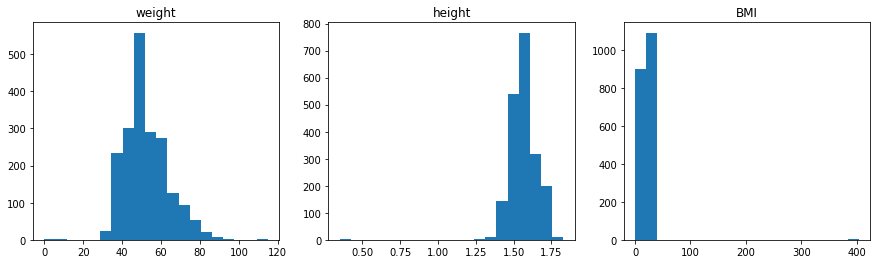

In [ ]:
# Let's first look at the variables Weight, Height and BMI

variables_to_visualize = ['weight', 'height', 'BMI']
fig, axes = plt.subplots(1, 3,figsize=[15,4])
axes = axes.flatten()

i = 0
for var in variables_to_visualize:
  plt.sca(axes[i])
  plt.hist([numerical_data[var]], bins=20)
  plt.title(var)
  i+=1
plt.show()

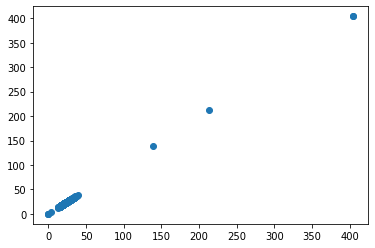

In [ ]:
def calculBMI(height,weight):
  return weight/(height*height)

plt.plot(numerical_data['BMI'],calculBMI(numerical_data['height'],numerical_data['weight']),'o')

We can notice outliers in those distributions: weight below 20kg, height below 1m and BMI above 50. \\
Moreover, those variables are correlated, and we decide to keep only the BMI since it is the one linked with the 2 other ones.

In [ ]:
numerical_data.drop(['height', 'weight'], axis=1, inplace=True)

In [ ]:
numerical_data[numerical_data['BMI'] > 50]['BMI']

# 4 patients have a BMI above 50 and present aberrant values.
# BMI might be an important variable and it is not easy to impute it, therefore we decide
# to discard those 4 observations

317    212.673611
320    404.081633
335    138.888889
562    404.081633
Name: BMI, dtype: float64

In [ ]:
index_obs_to_keep = numerical_data.loc[numerical_data['BMI'] <= 50].index
numerical_data = numerical_data.loc[index_obs_to_keep]
numerical_data.head()

# Do not forget to remove them from the categorical data df
categorical_data = categorical_data.loc[index_obs_to_keep]

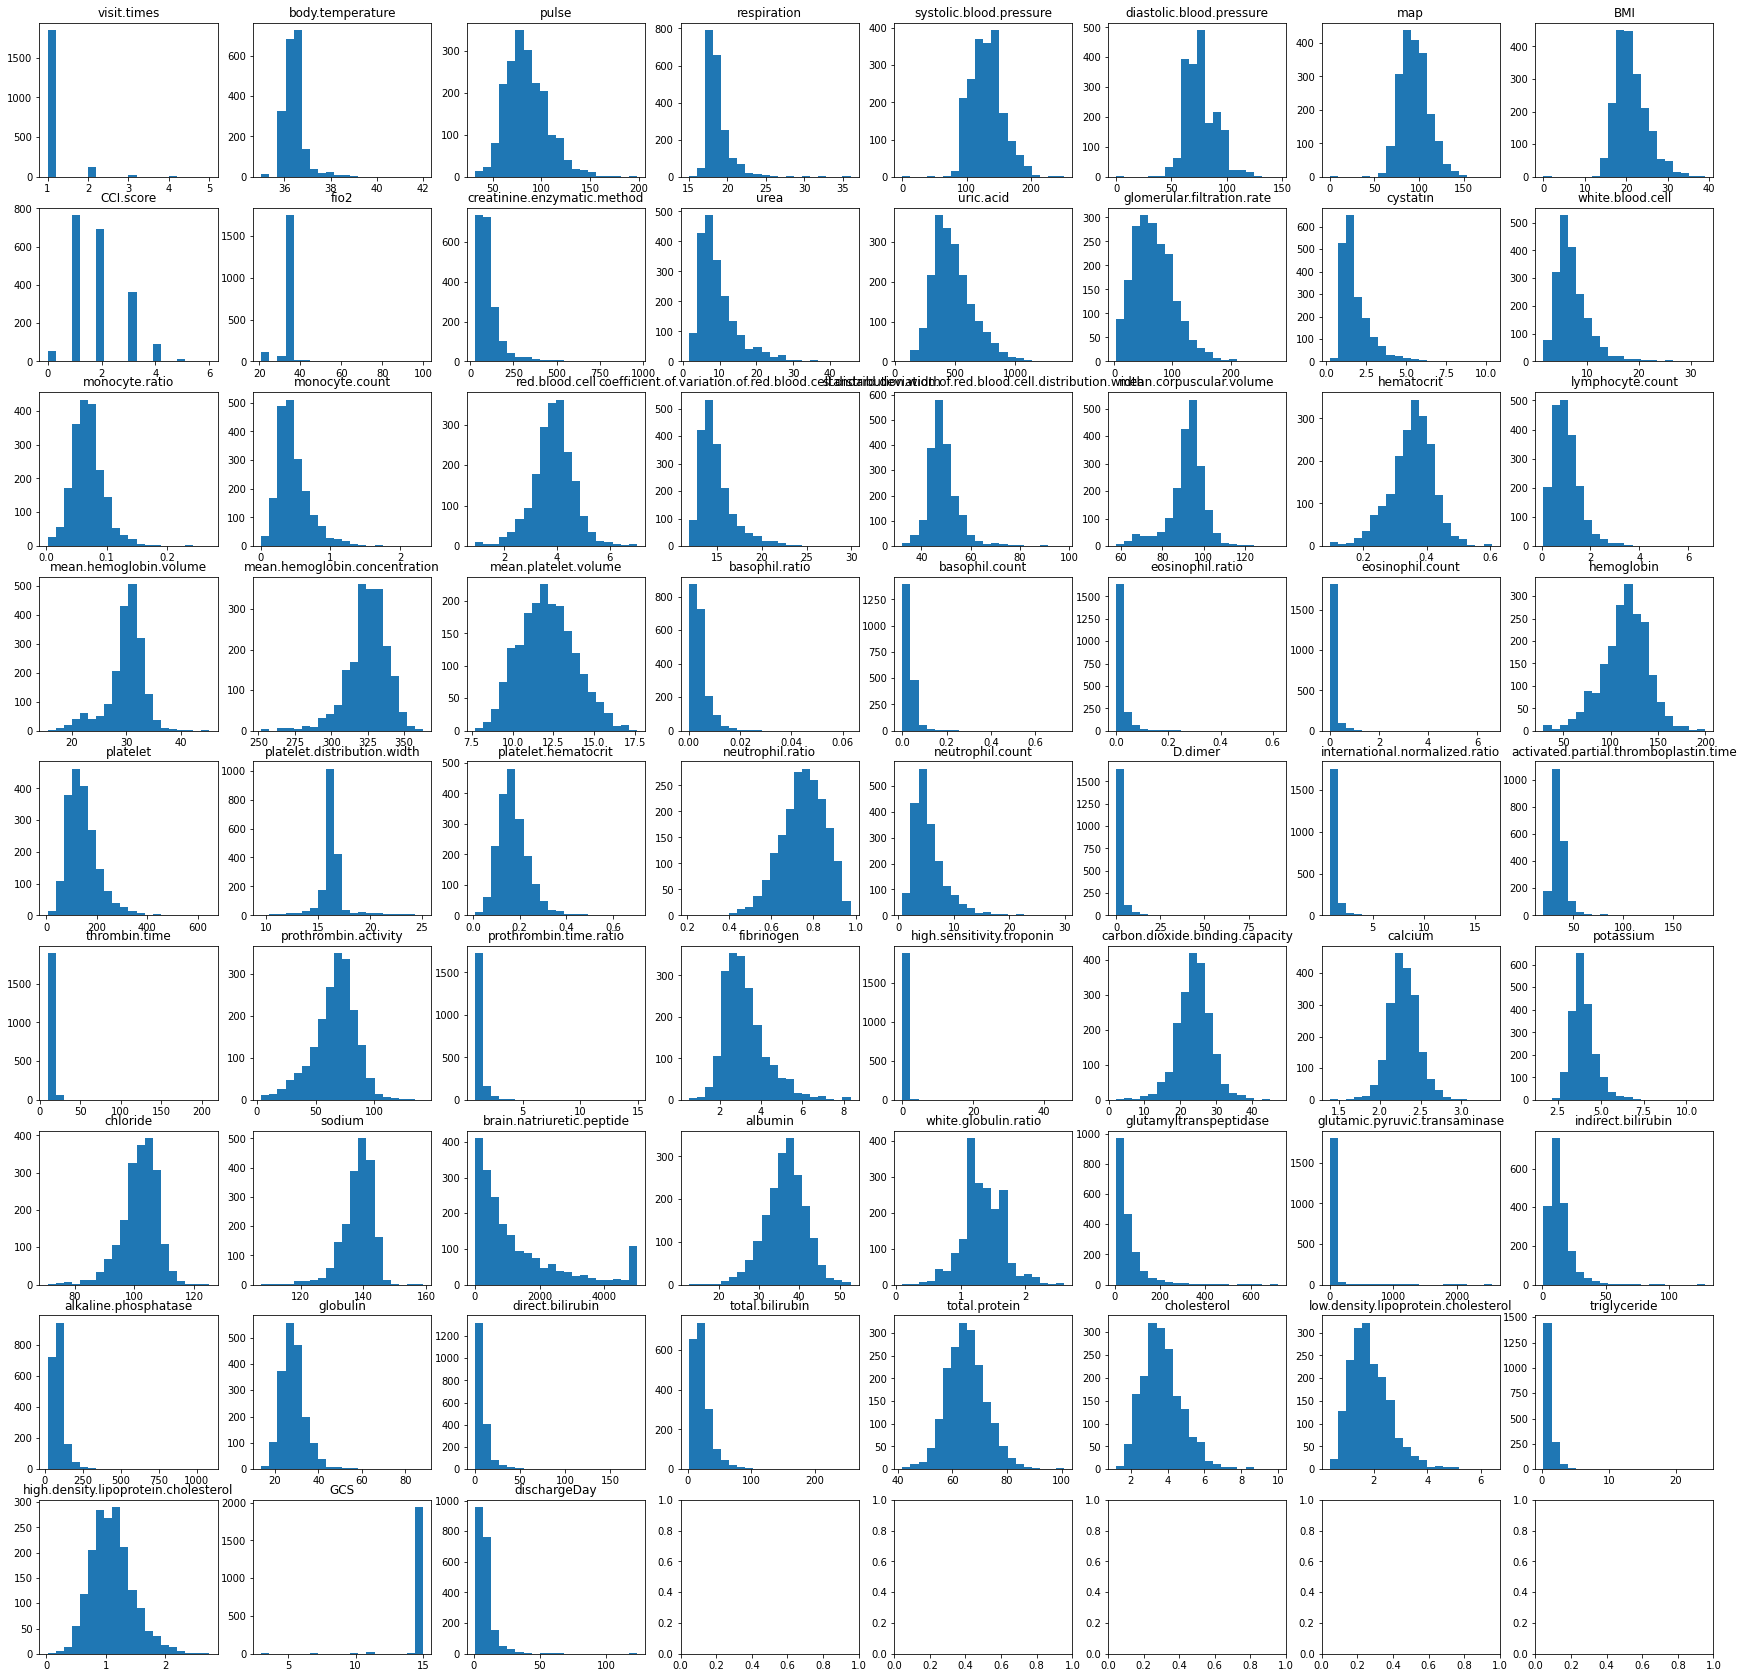

In [ ]:
# Visualize the numerical variables
fig, axes = plt.subplots(9, 8,figsize=[30,30])
axes = axes.flatten()

i = 0
for var in numerical_data.columns:
  plt.sca(axes[i])
  plt.hist([numerical_data[var]], bins=20)
  plt.title(var)
  i+=1
plt.show()

The other numerical variables do not seem to present outliers and/or aberrant values. \\

Let's now look at the categorical variables:

###For categorical variables

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


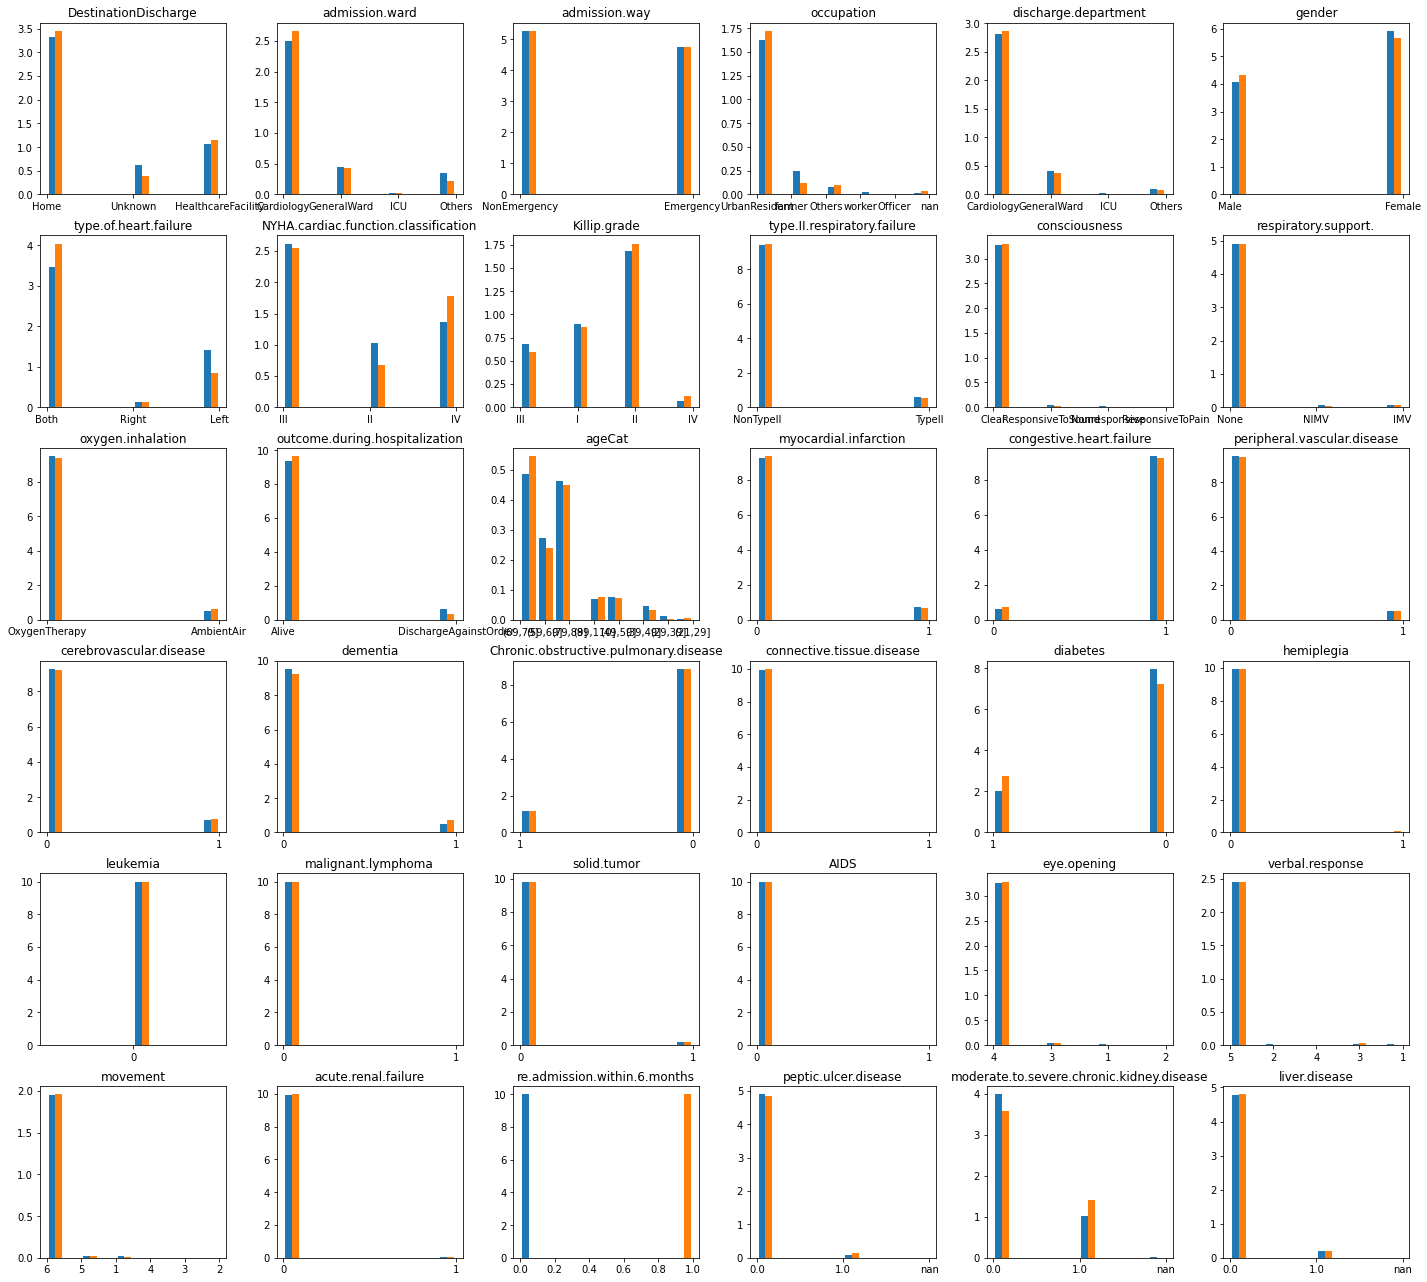

In [ ]:
categorical_data = categorical_data.astype(str)
categorical_data['re.admission.within.6.months'] = categorical_data['re.admission.within.6.months'].astype(float)
categorical_data_not_readmitted = categorical_data[categorical_data['re.admission.within.6.months']==0] # records with patients not readmitted
categorical_data_readmitted = categorical_data[categorical_data['re.admission.within.6.months']==1] # records with patients readmitted

fig, axes = plt.subplots(6, 6,figsize=[20,18])
axes = axes.flatten()
fig.tight_layout(pad=2)

i = 0
for x in categorical_data.columns:
    plt.sca(axes[i])
    plt.hist([categorical_data_not_readmitted[x], categorical_data_readmitted[x]],density=True)
    plt.title(x)
    i+=1
plt.show()

Those histograms show that the categorical variables do not present any outliers. They however have few NaNs, that will be replaced later on, after having split the dataset into train and test sets, to avoid including some information of the test set in the train set.

##Remove low variance and correlated features

### For numerical variables

Let's first check if there is any numerical variable having a very low variance. To do so, we need first to standardize those numerical variables and to compute their variance.

In [ ]:
# Scaler
scaler = StandardScaler().fit(numerical_data)
numerical_data_std = scaler.transform(numerical_data)

# Get variables having a variance very low (threshold=0.01)
vt = VarianceThreshold(threshold=(0.01)) 
vt.fit(numerical_data_std)
mask = vt.get_support()
numerical_data_std = pd.DataFrame(data=numerical_data_std, columns=numerical_data.columns)
numerical_data_std.loc[:, ~mask].shape

# There is no numerical variables having very low variance

(1988, 0)

Having highly correlated features in the dataset is not a good practice to train the model, therefore we should look and drop one of the two features involved in each correlated pair.

In [ ]:
# Extract correlated features
correlated_features = set()
correlation_matrix = numerical_data_std.corr()
median_corr = (correlation_matrix.abs()).median(axis=0)

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            if median_corr[i] > median_corr[j]:
                colname = correlation_matrix.columns[i]
            else:
                colname = correlation_matrix.columns[j]
            correlated_features.add(colname) 

print(correlated_features)

# Drop correlated features from the not-standardized numerical dataset
numerical_data.drop(labels=correlated_features, axis=1, inplace=True)
numerical_variables = list(numerical_data.columns)

numerical_data.head()

{'eosinophil.ratio', 'total.bilirubin', 'hematocrit', 'mean.hemoglobin.volume', 'neutrophil.count', 'international.normalized.ratio', 'platelet.hematocrit', 'map'}


,visit.times,body.temperature,pulse,respiration,systolic.blood.pressure,diastolic.blood.pressure,BMI,CCI.score,fio2,creatinine.enzymatic.method,...,alkaline.phosphatase,globulin,direct.bilirubin,total.protein,cholesterol,low.density.lipoprotein.cholesterol,triglyceride,high.density.lipoprotein.cholesterol,GCS,dischargeDay
1,1,36.7,87,19,102,64,18.590125,2.0,33,108.3,...,61.0,23.8,6.9,61.9,3.46,1.90,2.69,0.84,15,11
2,1,36.8,95,18,150,70,19.195303,0.0,33,62.0,...,69.0,25.4,5.2,66.1,3.15,1.26,0.84,1.30,15,8
3,2,36.5,98,18,102,67,24.221453,0.0,33,185.1,...,76.0,27.7,4.4,60.8,3.79,2.13,1.53,0.94,15,5
4,1,36.0,73,19,110,74,22.491349,2.0,33,104.8,...,191.0,27.0,25.4,67.1,2.92,1.31,0.92,0.98,15,11
5,1,35.0,88,19,134,62,31.633715,0.0,33,83.9,...,61.0,29.6,4.9,71.9,2.68,1.21,0.62,0.91,15,5


### For categorical variables

Looking at the histograms plotted above for the categorical variables, we can see that some of them have almost all values belonging to the same category. If the values belonging to the minor category are equally distributed with respect to the target variable, we should drop them. 

In [ ]:
to_remove = []

for x in categorical_data.columns:
  y = data[x].value_counts(dropna=False) / 2008
  if y.iloc[0] > 0.97:      
     to_remove.append(x)

print(to_remove)
print('{} categorical variables have at least 97% of the observations belonging to the same category.'.format(len(to_remove)))

['consciousness', 'respiratory.support.', 'connective.tissue.disease', 'hemiplegia', 'leukemia', 'malignant.lymphoma', 'solid.tumor', 'AIDS', 'eye.opening', 'verbal.response', 'movement', 'acute.renal.failure']
12 categorical variables have at least 97% of the observations belonging to the same category.


In [ ]:
categorical_data.drop(to_remove, axis=1, inplace=True)

In [ ]:
categorical_data.head()

,DestinationDischarge,admission.ward,admission.way,occupation,discharge.department,gender,type.of.heart.failure,NYHA.cardiac.function.classification,Killip.grade,type.II.respiratory.failure,...,congestive.heart.failure,peripheral.vascular.disease,cerebrovascular.disease,dementia,Chronic.obstructive.pulmonary.disease,diabetes,re.admission.within.6.months,peptic.ulcer.disease,moderate.to.severe.chronic.kidney.disease,liver.disease
1,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,Male,Both,III,III,NonTypeII,...,0,0,0,0,1,1,0.0,0.0,0.0,0.0
2,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,Female,Both,III,I,NonTypeII,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
3,Home,Cardiology,NonEmergency,farmer,Cardiology,Male,Both,II,II,NonTypeII,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
4,Home,Cardiology,Emergency,UrbanResident,Cardiology,Male,Both,III,II,NonTypeII,...,0,0,0,0,1,0,1.0,0.0,1.0,0.0
5,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,Female,Both,III,II,NonTypeII,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0


## Categorical variables' categories transformation

In this part, we need to transform the categories of the categorical variables in order to reduce their numbers when possible, and to create dummy variables when needed.

In [ ]:
categorical_data.columns

Index(['DestinationDischarge', 'admission.ward', 'admission.way', 'occupation',
       'discharge.department', 'gender', 'type.of.heart.failure',
       'NYHA.cardiac.function.classification', 'Killip.grade',
       'type.II.respiratory.failure', 'oxygen.inhalation',
       'outcome.during.hospitalization', 'ageCat', 'myocardial.infarction',
       'congestive.heart.failure', 'peripheral.vascular.disease',
       'cerebrovascular.disease', 'dementia',
       'Chronic.obstructive.pulmonary.disease', 'diabetes',
       're.admission.within.6.months', 'peptic.ulcer.disease',
       'moderate.to.severe.chronic.kidney.disease', 'liver.disease'],
      dtype='object')

In [ ]:
categorical_data['NYHA.cardiac.function.classification'].value_counts() 
# Belonging to the IV class is worse than belonging to the class I, therefore the order has a meaning
# We replace the classes I, II, III and IV with 1, 2, 3 and 4

III    1031
IV      606
II      351
Name: NYHA.cardiac.function.classification, dtype: int64

In [ ]:
categorical_data['NYHA.cardiac.function.classification'].replace('II', 2, inplace=True)
categorical_data['NYHA.cardiac.function.classification'].replace('III', 3, inplace=True)
categorical_data['NYHA.cardiac.function.classification'].replace('IV', 4, inplace=True)
categorical_data['NYHA.cardiac.function.classification'].value_counts() 

3    1031
4     606
2     351
Name: NYHA.cardiac.function.classification, dtype: int64

In [ ]:
categorical_data['Killip.grade'].value_counts()
# Similarly as the NYHA, we can replace with 1, 2, 3 and 4 the grades

II     1021
I       526
III     388
IV       53
Name: Killip.grade, dtype: int64

In [ ]:
categorical_data['Killip.grade'].replace('I', 1, inplace=True)
categorical_data['Killip.grade'].replace('II', 2, inplace=True)
categorical_data['Killip.grade'].replace('III', 3, inplace=True)
categorical_data['Killip.grade'].replace('IV', 4, inplace=True)
categorical_data['Killip.grade'].value_counts() 

2    1021
1     526
3     388
4      53
Name: Killip.grade, dtype: int64

In [ ]:
categorical_data['ageCat'].value_counts() 
# Being older increases the risk of heart failure, therefore we should convert each age category in a number

(69,79]     710
(79,89]     638
(59,69]     362
(49,59]     105
(89,110]    101
(39,49]      56
(29,39]      12
(21,29]       4
Name: ageCat, dtype: int64

In [ ]:
categorical_data['ageCat'].replace('(21,29]', 1, inplace=True)
categorical_data['ageCat'].replace('(29,39]', 2, inplace=True)
categorical_data['ageCat'].replace('(39,49]', 3, inplace=True)
categorical_data['ageCat'].replace('(49,59]', 4, inplace=True)
categorical_data['ageCat'].replace('(59,69]', 5, inplace=True)
categorical_data['ageCat'].replace('(69,79]', 6, inplace=True)
categorical_data['ageCat'].replace('(79,89]', 7, inplace=True)
categorical_data['ageCat'].replace('(89,110]', 8, inplace=True)

categorical_data['ageCat'].value_counts() 

6    710
7    638
5    362
4    105
8    101
3     56
2     12
1      4
Name: ageCat, dtype: int64

In [ ]:
categorical_data.drop(['occupation'], axis=1, inplace=True)

In [ ]:
variables_dummy_transform = categorical_data.columns.drop(['NYHA.cardiac.function.classification', 'Killip.grade', 'ageCat',
                                                           'myocardial.infarction', 'congestive.heart.failure', 'peripheral.vascular.disease',
                                                           'cerebrovascular.disease', 'dementia', 'Chronic.obstructive.pulmonary.disease',
                                                           'diabetes', 'peptic.ulcer.disease', 'moderate.to.severe.chronic.kidney.disease',
                                                           'liver.disease', 're.admission.within.6.months'])

In [ ]:
dummies = pd.get_dummies(categorical_data[variables_dummy_transform], drop_first=True)
dummies.head()

,DestinationDischarge_Home,DestinationDischarge_Unknown,admission.ward_GeneralWard,admission.ward_ICU,admission.ward_Others,admission.way_NonEmergency,discharge.department_GeneralWard,discharge.department_ICU,discharge.department_Others,gender_Male,type.of.heart.failure_Left,type.of.heart.failure_Right,type.II.respiratory.failure_TypeII,oxygen.inhalation_OxygenTherapy,outcome.during.hospitalization_DischargeAgainstOrder
1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0
2,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
5,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [ ]:
#We transformed the value "Both" for the type of heart failure witch was associated to two zeros for "Left3 and "Right" into two ones for the two dummies.
dummies.loc[(dummies['type.of.heart.failure_Right'] == 0) & (dummies['type.of.heart.failure_Left'] == 0), ['type.of.heart.failure_Left', 'type.of.heart.failure_Right']] = 1, 1

dummies['type.of.heart.failure_Left'].value_counts()

1    1937
0      51
Name: type.of.heart.failure_Left, dtype: int64

In [ ]:
categorical_data.drop(variables_dummy_transform, axis=1, inplace=True)

## Merged dataset

In [ ]:
categorical_data.shape, dummies.shape, numerical_data.shape

((1988, 14), (1988, 15), (1988, 59))

In [ ]:
# Merge numerical and categorical variables
merged_data = pd.concat([numerical_data, dummies, categorical_data], axis=1)
merged_data.tail()

,visit.times,body.temperature,pulse,respiration,systolic.blood.pressure,diastolic.blood.pressure,BMI,CCI.score,fio2,creatinine.enzymatic.method,...,congestive.heart.failure,peripheral.vascular.disease,cerebrovascular.disease,dementia,Chronic.obstructive.pulmonary.disease,diabetes,re.admission.within.6.months,peptic.ulcer.disease,moderate.to.severe.chronic.kidney.disease,liver.disease
2004,1,36.1,117,22,120,80,15.555556,2.0,33,115.3,...,1,0,0,0,0,0,0.0,0.0,1.0,0.0
2005,1,36.3,70,21,120,86,20.811655,1.0,29,63.1,...,1,0,0,0,0,0,0.0,0.0,0.0,0.0
2006,1,36.8,113,19,135,100,25.951557,2.0,33,51.9,...,1,0,0,0,0,1,1.0,0.0,0.0,0.0
2007,1,36.4,134,19,92,72,17.777778,2.0,41,191.1,...,1,0,0,0,0,0,0.0,0.0,1.0,0.0
2008,1,36.3,100,19,142,80,18.730489,2.0,33,104.0,...,1,0,0,0,0,0,0.0,0.0,1.0,0.0


In [ ]:
print(merged_data.shape)

(1988, 88)


## Remove patients having a lot of NaNs

The last step of the data processing phase is to look at the observations and to remove the ones having a lot of NaNs.

False    1980
True        8
dtype: int64


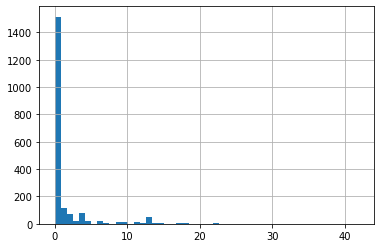

In [ ]:
# Look at the nb of NaNs per patients
merged_data.isnull().sum(axis=1).hist(bins=50)
print((merged_data.isnull().sum(axis=1) > 25).value_counts()) # True designates the nb of patients having at least x NaN

In [ ]:
merged_data = pd.DataFrame(merged_data[(merged_data.isnull().sum(axis = 1) <= 25).values])
merged_data.reset_index(drop=True, inplace=True)
merged_data

,visit.times,body.temperature,pulse,respiration,systolic.blood.pressure,diastolic.blood.pressure,BMI,CCI.score,fio2,creatinine.enzymatic.method,...,congestive.heart.failure,peripheral.vascular.disease,cerebrovascular.disease,dementia,Chronic.obstructive.pulmonary.disease,diabetes,re.admission.within.6.months,peptic.ulcer.disease,moderate.to.severe.chronic.kidney.disease,liver.disease
0,1,36.7,87,19,102,64,18.590125,2.0,33,108.3,...,0,0,0,0,1,1,0.0,0.0,0.0,0.0
1,1,36.8,95,18,150,70,19.195303,0.0,33,62.0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
2,2,36.5,98,18,102,67,24.221453,0.0,33,185.1,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
3,1,36.0,73,19,110,74,22.491349,2.0,33,104.8,...,0,0,0,0,1,0,1.0,0.0,1.0,0.0
4,1,35.0,88,19,134,62,31.633715,0.0,33,83.9,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,1,36.1,117,22,120,80,15.555556,2.0,33,115.3,...,1,0,0,0,0,0,0.0,0.0,1.0,0.0
1976,1,36.3,70,21,120,86,20.811655,1.0,29,63.1,...,1,0,0,0,0,0,0.0,0.0,0.0,0.0
1977,1,36.8,113,19,135,100,25.951557,2.0,33,51.9,...,1,0,0,0,0,1,1.0,0.0,0.0,0.0
1978,1,36.4,134,19,92,72,17.777778,2.0,41,191.1,...,1,0,0,0,0,0,0.0,0.0,1.0,0.0


##Balanced dataset?

Before splitting into train and test sets, we should look at the distribution of the target variable, to understand if we are facing an unbalanced problem.

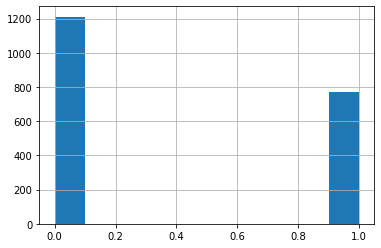

In [ ]:
merged_data['re.admission.within.6.months'].hist()

##Split train and test sets

In [ ]:
# Let's first split the features from the target
X = merged_data.drop(['re.admission.within.6.months'], axis=1)
y = merged_data['re.admission.within.6.months']

In [ ]:
X = X.astype('float32')
y = y.astype('int32')

In [ ]:
# Train and test spliting with stratification since the dataset is unbalanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1584, 87), (396, 87), (1584,), (396,))

##Missing value dealing

We should now impute values for all the NaNs in the dataset. To do so, we will use the median of the variables based on the target class the observation belongs to. \\
The medians are computed on the train set and are used to impute NaN both in the train and test sets, to avoid including information of the test set in the train.

In [ ]:
# Get the names of the variables having NaNs
variables_having_NaN = list(X.columns[X.isna().sum(axis=0) > 0])
variables_having_NaN.append('moderate.to.severe.chronic.kidney.disease')
variables_having_NaN.append('liver.disease')

In [ ]:
# Compute the means of all the features containing NaN according to the target class in the training set
medians_not_readmitted = {}
medians_readmitted = {}

for var in variables_having_NaN:
  not_readmitted_mean_value = np.mean(X_train[var][y_train == 0])
  readmitted_mean_value = np.mean(X_train[var][y_train == 1])
  if var == 'moderate.to.severe.chronic.kidney.disease' or var == 'liver.disease':
    medians_not_readmitted[var] = round(not_readmitted_mean_value)
    medians_readmitted[var] = round(readmitted_mean_value)
  else:
    medians_not_readmitted[var] = not_readmitted_mean_value
    medians_readmitted[var] = readmitted_mean_value

print(medians_not_readmitted)

{'CCI.score': 1.7774326801300049, 'creatinine.enzymatic.method': 104.42741394042969, 'urea': 9.13860034942627, 'uric.acid': 467.6329650878906, 'glomerular.filtration.rate': 72.45777893066406, 'cystatin': 1.8018028736114502, 'white.blood.cell': 7.353065490722656, 'monocyte.ratio': 0.06872542202472687, 'monocyte.count': 0.47748443484306335, 'red.blood.cell': 3.907891035079956, 'coefficient.of.variation.of.red.blood.cell.distribution.width': 14.796866416931152, 'standard.deviation.of.red.blood.cell.distribution.width': 48.410133361816406, 'mean.corpuscular.volume': 91.94159698486328, 'lymphocyte.count': 1.0285176038742065, 'mean.hemoglobin.concentration': 325.1388244628906, 'mean.platelet.volume': 12.166056632995605, 'basophil.ratio': 0.004292283672839403, 'basophil.count': 0.028977245092391968, 'eosinophil.count': 0.11311058700084686, 'hemoglobin': 116.65031433105469, 'platelet': 145.04383850097656, 'platelet.distribution.width': 16.3818416595459, 'neutrophil.ratio': 0.7530763745307922, 

In [ ]:
# Replace the NaN in the train set
X_train[y_train == 0] = X_train[y_train == 0].fillna(medians_not_readmitted)
X_train[y_train == 1] = X_train[y_train == 1].fillna(medians_readmitted)

# Check whether there is no NaNs anymore
X_train.columns[X_train.isna().sum(axis=0) > 0]

Index([], dtype='object')

In [ ]:
# Replace the NaN in the test set
X_test[y_test == 0] = X_test[y_test == 0].fillna(medians_not_readmitted)
X_test[y_test == 1] = X_test[y_test == 1].fillna(medians_readmitted)

# Check whether there is no NaNs anymore
X_test.columns[X_test.isna().sum(axis=0) > 0]

Index([], dtype='object')

##Standardization

The last step before training the models is to standardize the numerical variables. \\
As before, it is a good practice to learn the scaler on the training set and to transform both the train and test sets with this scaler.

In [ ]:
# DestinationDischarge_Home is the 1st categorical variable
X_train.iloc[:,:59]

,visit.times,body.temperature,pulse,respiration,systolic.blood.pressure,diastolic.blood.pressure,BMI,CCI.score,fio2,creatinine.enzymatic.method,...,alkaline.phosphatase,globulin,direct.bilirubin,total.protein,cholesterol,low.density.lipoprotein.cholesterol,triglyceride,high.density.lipoprotein.cholesterol,GCS,dischargeDay
637,1.0,36.099998,80.0,20.0,144.0,95.0,22.038567,4.0,29.0,131.600006,...,46.0,26.900000,13.3,62.599998,3.50,1.84,0.49,1.35,15.0,18.0
724,1.0,36.900002,95.0,20.0,143.0,60.0,23.624447,1.0,33.0,115.699997,...,84.0,28.600000,6.1,63.400002,3.63,2.04,0.94,1.02,15.0,8.0
1313,1.0,36.500000,108.0,18.0,120.0,76.0,19.979189,3.0,33.0,40.099998,...,66.0,26.500000,4.1,66.900002,2.97,0.97,0.38,1.61,15.0,8.0
700,1.0,36.500000,114.0,19.0,110.0,60.0,26.063101,1.0,29.0,104.427414,...,118.0,28.100000,4.9,64.699997,4.67,2.51,1.09,1.30,15.0,10.0
664,1.0,36.299999,60.0,18.0,160.0,90.0,27.343750,3.0,33.0,59.599998,...,71.0,34.299999,14.5,69.699997,2.94,1.28,0.70,1.14,15.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,1.0,36.200001,88.0,17.0,105.0,60.0,20.312500,2.0,33.0,59.200001,...,38.0,23.299999,11.5,57.500000,2.64,1.59,0.73,0.54,15.0,8.0
1836,1.0,36.500000,120.0,21.0,153.0,89.0,15.306123,2.0,33.0,29.700001,...,181.0,26.000000,8.6,66.199997,4.00,1.68,1.02,1.60,15.0,5.0
1877,1.0,36.200001,156.0,19.0,110.0,68.0,18.424036,3.0,33.0,59.299999,...,53.0,18.700001,5.2,53.400002,3.06,1.45,1.91,0.80,15.0,9.0
1613,1.0,36.500000,77.0,18.0,99.0,50.0,23.437500,1.0,33.0,74.099998,...,198.0,38.700001,9.5,65.300003,2.05,0.94,0.82,0.67,15.0,25.0


In [ ]:
# Learn scaler on train numerical variables
scaler = StandardScaler().fit(X_train.iloc[:,:59])

# Standardize train set
X_train.iloc[:,:59] = scaler.transform(X_train.iloc[:,:59])

# Standardize test set
X_test.iloc[:,:59] = scaler.transform(X_test.iloc[:,:59])

In [ ]:
X_train.head()

,visit.times,body.temperature,pulse,respiration,systolic.blood.pressure,diastolic.blood.pressure,BMI,CCI.score,fio2,creatinine.enzymatic.method,...,myocardial.infarction,congestive.heart.failure,peripheral.vascular.disease,cerebrovascular.disease,dementia,Chronic.obstructive.pulmonary.disease,diabetes,peptic.ulcer.disease,moderate.to.severe.chronic.kidney.disease,liver.disease
637,-0.245667,-0.719474,-0.251073,0.566557,0.523647,1.252250,0.195711,2.282993,-0.889689,0.313154,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
724,-0.245667,1.067155,0.458260,0.566557,0.482573,-1.151571,0.597931,-0.898699,0.100139,0.103720,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1313,-0.245667,0.173840,1.073016,-0.682470,-0.462139,-0.052681,-0.326601,1.222429,0.100139,-0.892081,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
700,-0.245667,0.173840,1.356749,-0.057957,-0.872884,-1.151571,1.216437,-0.898699,-0.889689,-0.044762,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
664,-0.245667,-0.272817,-1.196851,-0.682470,1.180838,0.908847,1.541243,1.222429,0.100139,-0.635228,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


## Models

In this section are developed the different classifiers and ensemble methods used to predict the readmission at 6 months of heart failure patients.


### Hyperparameter search function

In [ ]:
def hyperp_search(classifier, parameters, k, X_train, y_train, X_test, y_test):
    ''' This function takes as input a classifier (e.g. Decision Tree), a dictionary of parameters, the number of folds k for the cross-valdiation,
                                     the train (X_train, y_train) and the test (X_test, y_test) sets
                      performs a grid search using the cross-validation method and stores the best set of parameters looking at the performances on the validation sets
                      prints the different metrics on the train and the test sets
                      returns the best model fitted (refit=True) on the best set of parameters found
    '''

    # Hyperparameter tuning via cross-validation
    gs = GridSearchCV(classifier, parameters, cv=k, scoring = 'f1', refit=True, verbose=0, n_jobs=-1) # refit=True refits the model with the best found parameters on the whole dataset
    gs = gs.fit(X_train, y_train)

    # Prediction on train and test sets with best model found
    best_model = gs.best_estimator_
    y_test_pred = best_model.predict(X_test)
    y_train_pred = best_model.predict(X_train)

    # Results display
    print("\n \033[1m ***Best result obtained*** \033[0m \n")
    print("f1 (mean cross-validated score): %f using %s" % (gs.best_score_, gs.best_params_))

    print("\n \033[1m ***Scores obtained on train and test sets with best model*** \033[0m \n")
    print("f1          train %.3f   test %.3f" % (f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred))) 
    print("recall      train %.3f   test %.3f" % (recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred))) 
    print("precision   train %.3f   test %.3f" % (precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred))) 
    print("accuracy    train %.3f   test %.3f" % (accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred))) 

    print("\n \033[1m ***Classification report on test set*** \033[0m \n")
    print(classification_report(y_test, y_test_pred, target_names=['Not Readmitted', 'Readmitted']))

    print("\n \033[1m ***Confusion matrix on test set*** \033[0m \n")
    plot_confusion_matrix(best_model, X_test, y_test, display_labels=['Not Readmitted', 'Readmitted'], values_format='', cmap='Reds')

    return best_model

### Imbalanced dataset

#### Decision Tree

In [ ]:
classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'], 
              'max_depth': [5,8,10,15,20],
              'min_samples_split': [5,10,20],
              'min_samples_leaf': [5,10,20],
              'max_features': [None,10,20,30],
              'class_weight': [None,'balanced']}


  ***Best result obtained***  

f1 (mean cross-validated score): 0.553168 using {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 30, 'min_samples_leaf': 20, 'min_samples_split': 5}

  ***Scores obtained on train and test sets with best model***  

f1          train 0.643   test 0.537
recall      train 0.769   test 0.643
precision   train 0.552   test 0.460
accuracy    train 0.668   test 0.568

  ***Classification report on test set***  

                precision    recall  f1-score   support

Not Readmitted       0.70      0.52      0.60       242
    Readmitted       0.46      0.64      0.54       154

      accuracy                           0.57       396
     macro avg       0.58      0.58      0.57       396
  weighted avg       0.60      0.57      0.57       396


  ***Confusion matrix on test set***  



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


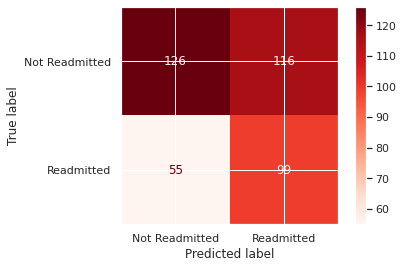

In [ ]:
best_model_tree_id = hyperp_search(classifier, parameters, 10, X_train, y_train, X_test, y_test)

In [ ]:
r = tree.export_text(best_model_tree_id, feature_names=X_test.columns.tolist(), max_depth=5)
print(r)

|--- D.dimer <= 0.06
|   |--- glomerular.filtration.rate <= -0.11
|   |   |--- white.globulin.ratio <= 0.01
|   |   |   |--- standard.deviation.of.red.blood.cell.distribution.width <= 1.12
|   |   |   |   |--- platelet.distribution.width <= -0.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- platelet.distribution.width >  -0.00
|   |   |   |   |   |--- class: 0
|   |   |   |--- standard.deviation.of.red.blood.cell.distribution.width >  1.12
|   |   |   |   |--- class: 1
|   |   |--- white.globulin.ratio >  0.01
|   |   |   |--- albumin <= 0.11
|   |   |   |   |--- glutamyltranspeptidase <= -0.37
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- glutamyltranspeptidase >  -0.37
|   |   |   |   |   |--- class: 1
|   |   |   |--- albumin >  0.11
|   |   |   |   |--- total.protein <= -0.37
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- total.protein >  -0.37
|   |   |   |   |   |--- class: 1
|   |--- glomerular.filtration.rate >  -0.11
|   |   |--- sodium <= -0.41
|   

#### Random Forest

In [ ]:
classifier = RandomForestClassifier()
parameters = {'n_estimators': [20], #50
              'criterion': ['entropy'], #gini
              'max_depth': [4], #5
              'max_features': [None], #20
              'class_weight': ['balanced'], #None
              'min_samples_split': [3],   #5
              'min_samples_leaf': [5]}  #3


  ***Best result obtained***  

f1 (mean cross-validated score): 0.555800 using {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 20}

  ***Scores obtained on train and test sets with best model***  

f1          train 0.704   test 0.517
recall      train 0.774   test 0.578
precision   train 0.645   test 0.468
accuracy    train 0.747   test 0.581

  ***Classification report on test set***  

                precision    recall  f1-score   support

Not Readmitted       0.68      0.58      0.63       242
    Readmitted       0.47      0.58      0.52       154

      accuracy                           0.58       396
     macro avg       0.58      0.58      0.57       396
  weighted avg       0.60      0.58      0.59       396


  ***Confusion matrix on test set***  



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


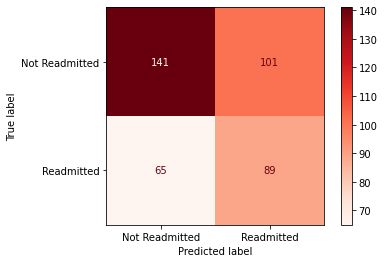

In [ ]:
best_model_rf_id = hyperp_search(classifier, parameters, 10, X_train, y_train, X_test, y_test)

#### Adaboost

In [ ]:
classifier = AdaBoostClassifier()
parameters = {'n_estimators': [10,50,100,250],
              'learning_rate': [0.0001,0.1,1,10]}


  ***Best result obtained***  

f1 (mean cross-validated score): 0.559337 using {'learning_rate': 10, 'n_estimators': 10}

  ***Scores obtained on train and test sets with best model***  

f1          train 0.559   test 0.560
recall      train 1.000   test 1.000
precision   train 0.388   test 0.389
accuracy    train 0.388   test 0.389

  ***Classification report on test set***  

                precision    recall  f1-score   support

Not Readmitted       0.00      0.00      0.00       242
    Readmitted       0.39      1.00      0.56       154

      accuracy                           0.39       396
     macro avg       0.19      0.50      0.28       396
  weighted avg       0.15      0.39      0.22       396


  ***Confusion matrix on test set***  



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py

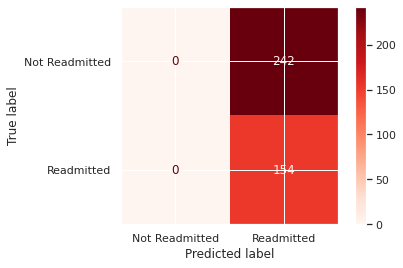

In [ ]:
best_model_adb_id = hyperp_search(classifier, parameters, 10, X_train, y_train, X_test, y_test)

#### XGBoost

In [ ]:
classifier = xgb.XGBClassifier()
parameters = {'max_depth': [3,4,5], 
              'n_estimators': [20,30], 
              'max_leaves': [10,20,30],
              'reg_lambda': [0,1,2],
              'reg_alpha': [0,1,2],
              'gamma': [1,2,3],
              'learning_rate': [0.1],
              'scale_pos_weight': [1,1.4]}


  ***Best result obtained***  

f1 (mean cross-validated score): 0.591945 using {'gamma': 3, 'learning_rate': 0.1, 'max_depth': 5, 'max_leaves': 10, 'n_estimators': 30, 'reg_alpha': 2, 'reg_lambda': 1, 'scale_pos_weight': 1.4}

  ***Scores obtained on train and test sets with best model***  

f1          train 0.897   test 0.576
recall      train 0.902   test 0.565
precision   train 0.892   test 0.588
accuracy    train 0.920   test 0.677

  ***Classification report on test set***  

                precision    recall  f1-score   support

Not Readmitted       0.73      0.75      0.74       242
    Readmitted       0.59      0.56      0.58       154

      accuracy                           0.68       396
     macro avg       0.66      0.66      0.66       396
  weighted avg       0.67      0.68      0.68       396


  ***Confusion matrix on test set***  



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


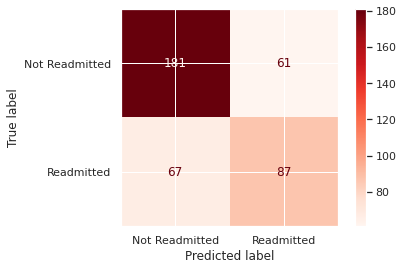

In [ ]:
best_model_xgb_id = hyperp_search(classifier, parameters, 10, X_train, y_train, X_test, y_test)

#### KNN

In [ ]:
classifier = KNeighborsClassifier()
parameters = {'n_neighbors': np.arange(10,500,20)}


  ***Best result obtained***  

f1 (mean cross-validated score): 0.384464 using {'n_neighbors': 10}

  ***Scores obtained on train and test sets with best model***  

f1          train 0.509   test 0.355
recall      train 0.402   test 0.279
precision   train 0.694   test 0.489
accuracy    train 0.699   test 0.606

  ***Classification report on test set***  

                precision    recall  f1-score   support

Not Readmitted       0.64      0.81      0.72       242
    Readmitted       0.49      0.28      0.36       154

      accuracy                           0.61       396
     macro avg       0.56      0.55      0.54       396
  weighted avg       0.58      0.61      0.58       396


  ***Confusion matrix on test set***  



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


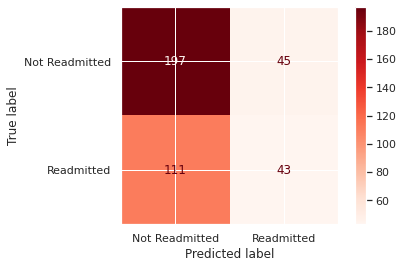

In [ ]:
best_model_knn_id = hyperp_search(classifier, parameters, 10, X_train, y_train, X_test, y_test)

#### Logistic Regression

In [ ]:
classifier = LogisticRegression()
parameters = {'penalty': ['l2', 'none'],
              'C': [1e-4,1e-3,1e-2,1e-1,1,10], 
              'class_weight': ['balanced', None],
              'max_iter': [500,1000]}


  ***Best result obtained***  

f1 (mean cross-validated score): 0.556156 using {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2'}

  ***Scores obtained on train and test sets with best model***  

f1          train 0.612   test 0.547
recall      train 0.681   test 0.643
precision   train 0.555   test 0.476
accuracy    train 0.664   test 0.586

  ***Classification report on test set***  

                precision    recall  f1-score   support

Not Readmitted       0.71      0.55      0.62       242
    Readmitted       0.48      0.64      0.55       154

      accuracy                           0.59       396
     macro avg       0.59      0.60      0.58       396
  weighted avg       0.62      0.59      0.59       396


  ***Confusion matrix on test set***  



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


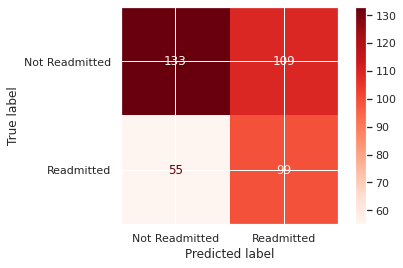

In [ ]:
best_model_lr_id = hyperp_search(classifier, parameters, 10, X_train, y_train, X_test, y_test)

#### SVM

In [ ]:
classifier = SVC()
parameters = [{'kernel': ['rbf'], 
               'gamma': [1e-3,1e-4],
               'C': [1,10],
               'class_weight': ['balanced', None],
               'probability': [True]},
              {'kernel': ['linear'],
               'C': [1,10],
               'class_weight': ['balanced', None],
               'probability': [True]},
              {'kernel': ['poly'],
               'C': [1,10],
               'degree': [2,3,4],
               'class_weight': ['balanced', None],
               'probability': [True]}]


  ***Best result obtained***  

f1 (mean cross-validated score): 0.552416 using {'C': 10, 'class_weight': 'balanced', 'gamma': 0.001, 'kernel': 'rbf', 'probability': True}

  ***Scores obtained on train and test sets with best model***  

f1          train 0.633   test 0.560
recall      train 0.683   test 0.636
precision   train 0.589   test 0.500
accuracy    train 0.692   test 0.611

  ***Classification report on test set***  

                precision    recall  f1-score   support

Not Readmitted       0.72      0.60      0.65       242
    Readmitted       0.50      0.64      0.56       154

      accuracy                           0.61       396
     macro avg       0.61      0.62      0.61       396
  weighted avg       0.63      0.61      0.62       396


  ***Confusion matrix on test set***  



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


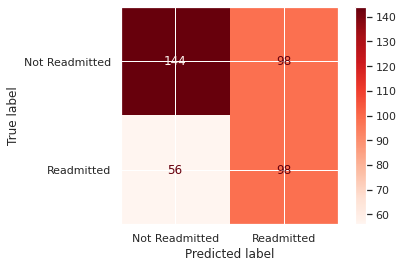

In [ ]:
best_model_svc_id = hyperp_search(classifier, parameters, 10, X_train, y_train, X_test, y_test)

#### Multi-layer Perceptron

In [ ]:
classifier = MLPClassifier()
parameters = {'hidden_layer_sizes': [(16,8),(32,16)],
              'max_iter': [100,200],
              'alpha': [0.01,0.1],
              'activation': ['tanh','relu']}

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)



  ***Best result obtained***  

f1 (mean cross-validated score): 0.507442 using {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (32, 16), 'max_iter': 100}

  ***Scores obtained on train and test sets with best model***  

f1          train 0.961   test 0.495
recall      train 0.959   test 0.481
precision   train 0.962   test 0.510
accuracy    train 0.970   test 0.619

  ***Classification report on test set***  

                precision    recall  f1-score   support

Not Readmitted       0.68      0.71      0.69       242
    Readmitted       0.51      0.48      0.49       154

      accuracy                           0.62       396
     macro avg       0.60      0.59      0.59       396
  weighted avg       0.61      0.62      0.62       396


  ***Confusion matrix on test set***  



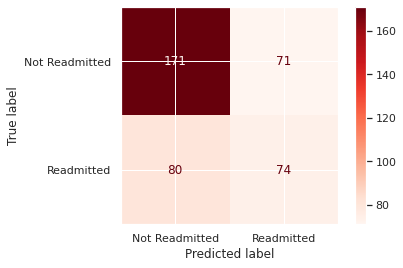

In [ ]:
best_model_mlp_id = hyperp_search(classifier, parameters, 10, X_train, y_train, X_test, y_test)

#### Naive Bayes

In [ ]:
classifier = GaussianNB()
parameters = {'var_smoothing': np.logspace(0,-9, num=100)}


  ***Best result obtained***  

f1 (mean cross-validated score): 0.553120 using {'var_smoothing': 5.336699231206302e-08}

  ***Scores obtained on train and test sets with best model***  

f1          train 0.568   test 0.549
recall      train 0.941   test 0.903
precision   train 0.407   test 0.395
accuracy    train 0.444   test 0.424

  ***Classification report on test set***  

                precision    recall  f1-score   support

Not Readmitted       0.66      0.12      0.20       242
    Readmitted       0.39      0.90      0.55       154

      accuracy                           0.42       396
     macro avg       0.53      0.51      0.38       396
  weighted avg       0.56      0.42      0.34       396


  ***Confusion matrix on test set***  



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


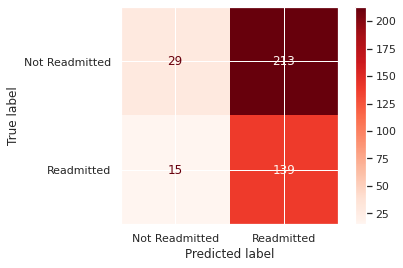

In [ ]:
best_model_nb_id = hyperp_search(classifier, parameters, 10, X_train, y_train, X_test, y_test)

From these first results, we can notice that the best models in terms of controlled overfitting and f1 score are the random forest classifier, the SVC and the logistic regression model. \
Let's try to run these models by using only the most useful features found by the model and the best set of parameters.

#### Training with reduced number of features

In [ ]:
def print_model_performances(classifier, X_train, y_train, X_test, y_test):

  # train/test predictions
  y_train_pred = classifier.predict(X_train)
  y_test_pred = classifier.predict(X_test)

  # f1, recall, precision, accuracy computed for both train and test sets
  print("\n \033[1m ***Scores obtained on train and test sets with best model*** \033[0m \n")
  print("f1          train %.3f   test %.3f" % (f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred))) 
  print("recall      train %.3f   test %.3f" % (recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred))) 
  print("precision   train %.3f   test %.3f" % (precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred))) 
  print("accuracy    train %.3f   test %.3f" % (accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred))) 

  print("\n \033[1m ***Classification report on test set*** \033[0m \n")
  print(classification_report(y_test, y_test_pred, target_names=['Not Readmitted', 'Readmitted']))

  # confusion matrix
  print("\n \033[1m ***Confusion matrix on test set*** \033[0m \n")
  plot_confusion_matrix(classifier, X_test, y_test, display_labels=['Not Readmitted', 'Readmitted'], values_format='', cmap='Reds')

  return 0

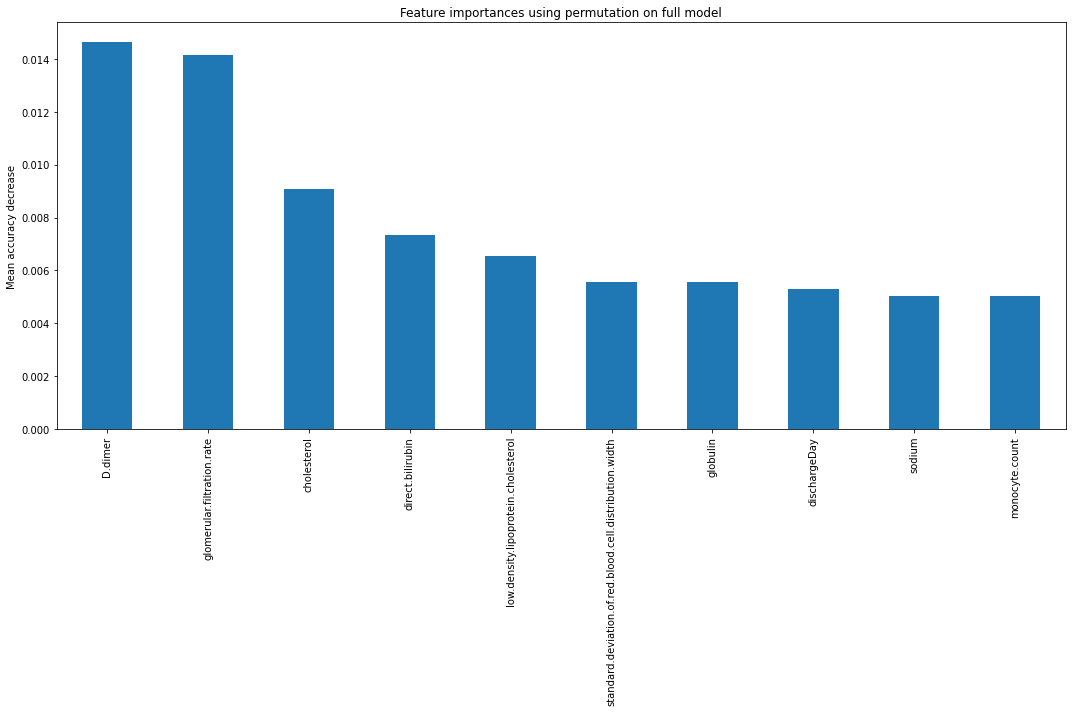

NameError: ignored

In [ ]:
from sklearn.inspection import permutation_importance

feature_names = X.columns

## Random Forest

# Compute importance
perm_importances_forest = permutation_importance(best_model_rf_id, X_test, y_test, n_repeats=10, random_state=42)
forest_importances = pd.Series(abs(perm_importances_forest.importances_mean), index=feature_names).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15,10))
forest_importances.plot.bar(yerr=perm_importances_forest.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# Define new training/test sets selecting either the 10 or the 20 most significant features
X_train_rf_10 = X_train[forest_importances.index[:10]]
X_test_rf_10 = X_test[forest_importances.index[:10]]
X_train_rf_20 = X_train[forest_importances.index[:20]]
X_test_rf_20 = X_test[forest_importances.index[:20]]

# Train the best model (best set of parameters found previously) with less features
# - 10 features
best_model_rf_id_10 = RandomForestClassifier(n_estimators=20, criterion='entropy', max_depth=4, max_features=None, class_weight='balanced', min_samples_split=3, min_samples_leaf=5)
best_model_rf_id_10.fit(X_train_rf_10, y_train)
print_model_performances(best_model_rf_id_10, X_train_rf_10, y_train, X_test_rf_10, y_test)
# - 20 features
best_model_rf_id_20 = RandomForestClassifier(n_estimators=20, criterion='entropy', max_depth=4, max_features=None, class_weight='balanced', min_samples_split=3, min_samples_leaf=5)
best_model_rf_id_20.fit(X_train_rf_20, y_train)
print_model_performances(best_model_rf_id_20, X_train_rf_20, y_train, X_test_rf_20, y_test)

# It increases the number of false positives 

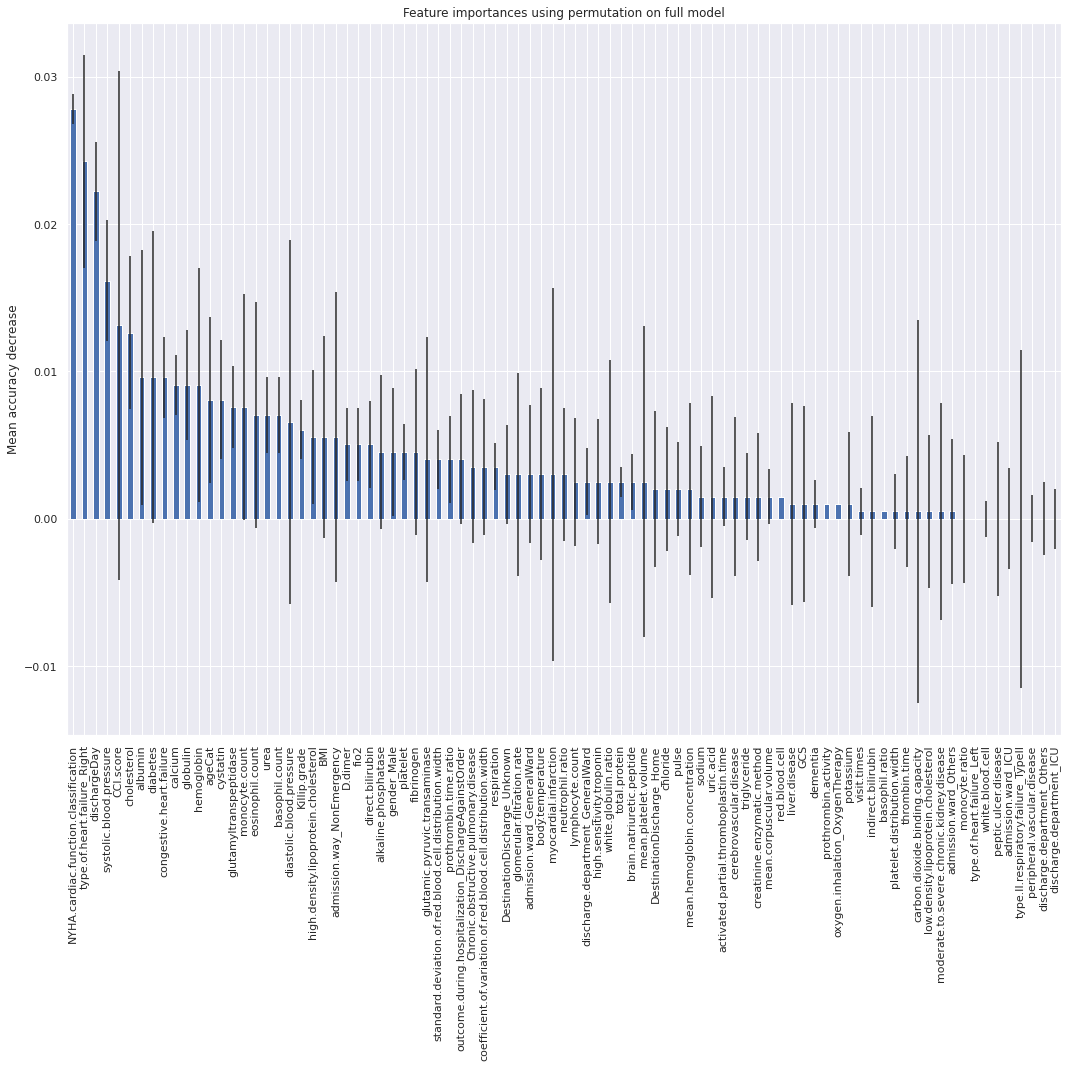


  ***Scores obtained on train and test sets with best model***  

f1          train 0.539   test 0.530
recall      train 0.582   test 0.610
precision   train 0.501   test 0.468
accuracy    train 0.613   test 0.578

  ***Classification report on test set***  

                precision    recall  f1-score   support

Not Readmitted       0.69      0.56      0.62       242
    Readmitted       0.47      0.61      0.53       154

      accuracy                           0.58       396
     macro avg       0.58      0.58      0.57       396
  weighted avg       0.60      0.58      0.58       396


  ***Confusion matrix on test set***  



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)



  ***Scores obtained on train and test sets with best model***  

f1          train 0.556   test 0.555
recall      train 0.602   test 0.656
precision   train 0.516   test 0.481
accuracy    train 0.626   test 0.591

  ***Classification report on test set***  

                precision    recall  f1-score   support

Not Readmitted       0.72      0.55      0.62       242
    Readmitted       0.48      0.66      0.55       154

      accuracy                           0.59       396
     macro avg       0.60      0.60      0.59       396
  weighted avg       0.62      0.59      0.60       396


  ***Confusion matrix on test set***  



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)



  ***Scores obtained on train and test sets with best model***  

f1          train 0.597   test 0.565
recall      train 0.665   test 0.675
precision   train 0.542   test 0.486
accuracy    train 0.652   test 0.596

  ***Classification report on test set***  

                precision    recall  f1-score   support

Not Readmitted       0.73      0.55      0.62       242
    Readmitted       0.49      0.68      0.57       154

      accuracy                           0.60       396
     macro avg       0.61      0.61      0.59       396
  weighted avg       0.63      0.60      0.60       396


  ***Confusion matrix on test set***  



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0

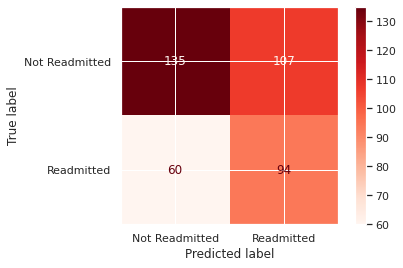

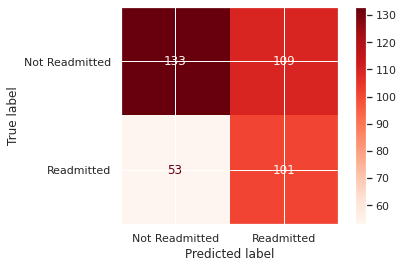

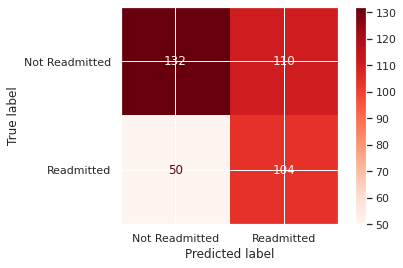

In [ ]:
## SVC

# Compute importance
perm_importances_svc = permutation_importance(best_model_svc_id, X_test, y_test, n_repeats=5, random_state=42)
svc_importances = pd.Series(abs(perm_importances_svc.importances_mean), index=feature_names).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15,15))
svc_importances.plot.bar(yerr=perm_importances_svc.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# Define new training/test sets selecting either the 10 or the 20 most significant features
X_train_svc_10 = X_train[svc_importances.index[:10]]
X_test_svc_10 = X_test[svc_importances.index[:10]]
X_train_svc_20 = X_train[svc_importances.index[:20]]
X_test_svc_20 = X_test[svc_importances.index[:20]]

# Train the best model (best set of parameters found previously) with less features
# - 10 features
best_model_svc_id_10 = SVC(C=10, class_weight='balanced', gamma=0.001, kernel='rbf', probability=True)
best_model_svc_id_10.fit(X_train_svc_10, y_train)
print_model_performances(best_model_svc_id_10, X_train_svc_10, y_train, X_test_svc_10, y_test)
# - 20 features
best_model_svc_id_20 = SVC(C=10, class_weight='balanced', gamma=0.001, kernel='rbf', probability=True)
best_model_svc_id_20.fit(X_train_svc_20, y_train)
print_model_performances(best_model_svc_id_20, X_train_svc_20, y_train, X_test_svc_20, y_test)


  ***Scores obtained on train and test sets with best model***  

f1          train 0.556   test 0.526
recall      train 0.631   test 0.623
precision   train 0.497   test 0.455
accuracy    train 0.609   test 0.563

  ***Classification report on test set***  

                precision    recall  f1-score   support

Not Readmitted       0.69      0.52      0.59       242
    Readmitted       0.45      0.62      0.53       154

      accuracy                           0.56       396
     macro avg       0.57      0.57      0.56       396
  weighted avg       0.60      0.56      0.57       396


  ***Confusion matrix on test set***  


  ***Scores obtained on train and test sets with best model***  

f1          train 0.566   test 0.515
recall      train 0.624   test 0.597
precision   train 0.518   test 0.453
accuracy    train 0.629   test 0.563

  ***Classification report on test set***  

                precision    recall  f1-score   support

Not Readmitted       0.68      0.54      

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0

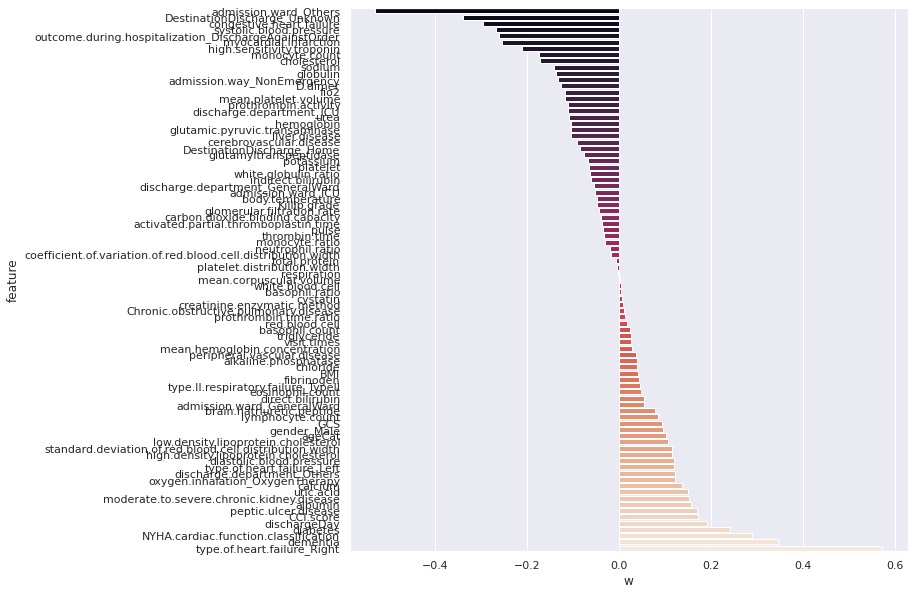

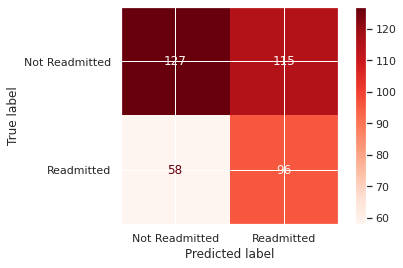

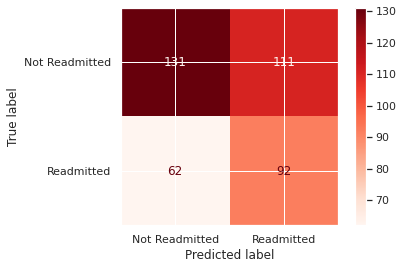

In [ ]:
## Logistic Regression

# Compute importance
coefficients = pd.DataFrame()
coefficients['feature'] = feature_names
coefficients['w'] = best_model_lr_id.coef_[0]

coefficients.sort_values(by=['w'], inplace=True)

sns.set(rc={'figure.figsize':(10,10)})
sns.barplot(data=coefficients, y='feature', x='w', palette='rocket', orient='h')
sns.set(rc={'figure.figsize':(6,4)})

# Define new training/test sets selecting either the 10 or the 20 most significant features
X_train_lr_10 = X_train[pd.concat([coefficients['feature'][:5], coefficients['feature'][-5:]])]
X_test_lr_10 = X_test[pd.concat([coefficients['feature'][:5], coefficients['feature'][-5:]])]
X_train_lr_20 = X_train[pd.concat([coefficients['feature'][:10], coefficients['feature'][-10:]])]
X_test_lr_20 = X_test[pd.concat([coefficients['feature'][:10], coefficients['feature'][-10:]])]

# Train the best model (best set of parameters found previously) with less features
# - 10 features
best_model_lr_id_10 = LogisticRegression(C=0.1, class_weight='balanced', max_iter=500, penalty='l2')
best_model_lr_id_10.fit(X_train_lr_10, y_train)
print_model_performances(best_model_lr_id_10, X_train_lr_10, y_train, X_test_lr_10, y_test)
# - 20 features
best_model_lr_id_20 = LogisticRegression(C=0.1, class_weight='balanced', max_iter=500, penalty='l2')
best_model_lr_id_20.fit(X_train_lr_20, y_train)
print_model_performances(best_model_lr_id_20, X_train_lr_20, y_train, X_test_lr_20, y_test)

In all cases, reducing the number of features slightly reduces the performances of the model.

### Balanced dataset

In this section, oversampling and downsampling are performed on the training set to investigate their impact on the performances in the 3 best models found until now.

#### Oversampling (SMOTE)

In [ ]:
oversample = SMOTE(random_state=42)
X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)


  ***Scores obtained on train and test sets with best model***  

f1          train 0.746   test 0.535
recall      train 0.769   test 0.571
precision   train 0.725   test 0.503
accuracy    train 0.739   test 0.614

  ***Classification report on test set***  

                precision    recall  f1-score   support

Not Readmitted       0.70      0.64      0.67       242
    Readmitted       0.50      0.57      0.53       154

      accuracy                           0.61       396
     macro avg       0.60      0.61      0.60       396
  weighted avg       0.62      0.61      0.62       396


  ***Confusion matrix on test set***  



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0

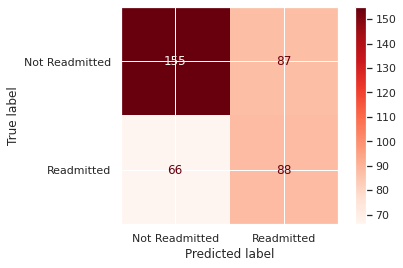

In [ ]:
# Random Forest
best_model_rf_os = RandomForestClassifier(n_estimators=20, criterion='entropy', max_depth=4, max_features=None, class_weight='balanced', min_samples_split=3, min_samples_leaf=5)
best_model_rf_os.fit(X_train_os, y_train_os)
print_model_performances(best_model_rf_os, X_train_os, y_train_os, X_test, y_test)


  ***Scores obtained on train and test sets with best model***  

f1          train 0.712   test 0.536
recall      train 0.724   test 0.610
precision   train 0.701   test 0.477
accuracy    train 0.707   test 0.588

  ***Classification report on test set***  

                precision    recall  f1-score   support

Not Readmitted       0.70      0.57      0.63       242
    Readmitted       0.48      0.61      0.54       154

      accuracy                           0.59       396
     macro avg       0.59      0.59      0.58       396
  weighted avg       0.61      0.59      0.59       396


  ***Confusion matrix on test set***  



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0

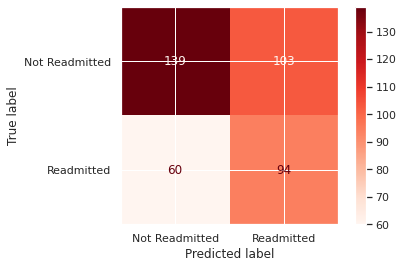

In [ ]:
# SVC
best_model_svc_os = SVC(C=10, class_weight='balanced', gamma=0.001, kernel='rbf', probability=True)
best_model_svc_os.fit(X_train_os, y_train_os)
print_model_performances(best_model_svc_os, X_train_os, y_train_os, X_test, y_test)


  ***Scores obtained on train and test sets with best model***  

f1          train 0.677   test 0.531
recall      train 0.688   test 0.636
precision   train 0.666   test 0.456
accuracy    train 0.672   test 0.563

  ***Classification report on test set***  

                precision    recall  f1-score   support

Not Readmitted       0.69      0.52      0.59       242
    Readmitted       0.46      0.64      0.53       154

      accuracy                           0.56       396
     macro avg       0.57      0.58      0.56       396
  weighted avg       0.60      0.56      0.57       396


  ***Confusion matrix on test set***  



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0

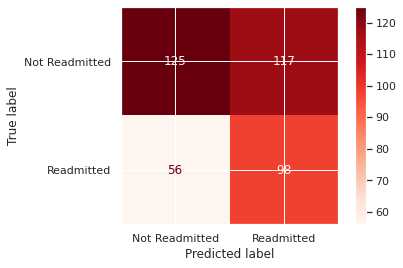

In [ ]:
# Logistic Regression
best_model_lr_os = LogisticRegression(C=0.1, class_weight='balanced', max_iter=500, penalty='l2')
best_model_lr_os.fit(X_train_os, y_train_os)
print_model_performances(best_model_lr_os, X_train_os, y_train_os, X_test, y_test)

#### Downsampling

In [ ]:
X_train_undersampled, y_train_undersampled = resample(X_train[y_train == 0], y_train[y_train == 0],
                                                      replace=True, n_samples=X_train[y_train == 1].shape[0], random_state=42)

X_train_ds = pd.DataFrame(np.vstack((X_train[y_train == 1], X_train_undersampled)), columns=X_train.columns)
y_train_ds = pd.Series(np.hstack((y_train[y_train == 1], y_train_undersampled)), name=y_train.name)


In [ ]:
# Shuffle dataset
df_train_ds = pd.concat([X_train_ds, y_train_ds], axis=1)
df_train_ds = shuffle(df_train_ds)
df_train_ds.reset_index(inplace=True)
df_train_ds.drop(['index'], axis=1, inplace=True)

X_train_ds = df_train_ds.loc[:, df_train_ds.columns != 're.admission.within.6.months']
y_train_ds = df_train_ds.loc[:, 're.admission.within.6.months']

In [ ]:
X_train_ds.shape

(1230, 87)


  ***Scores obtained on train and test sets with best model***  

f1          train 0.801   test 0.561
recall      train 0.826   test 0.701
precision   train 0.778   test 0.468
accuracy    train 0.795   test 0.573

  ***Classification report on test set***  

                precision    recall  f1-score   support

Not Readmitted       0.72      0.49      0.58       242
    Readmitted       0.47      0.70      0.56       154

      accuracy                           0.57       396
     macro avg       0.59      0.60      0.57       396
  weighted avg       0.62      0.57      0.58       396


  ***Confusion matrix on test set***  



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0

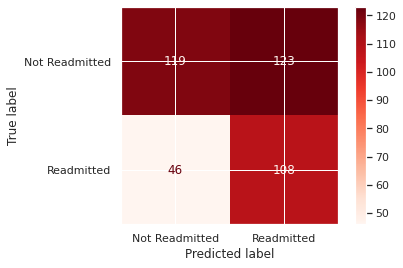

In [ ]:
# Random Forest
best_model_rf_ds = RandomForestClassifier(n_estimators=20, criterion='entropy', max_depth=4, max_features=None, class_weight='balanced', min_samples_split=3, min_samples_leaf=5)
best_model_rf_ds.fit(X_train_ds, y_train_ds)
print_model_performances(best_model_rf_ds, X_train_ds, y_train_ds, X_test, y_test)


  ***Scores obtained on train and test sets with best model***  

f1          train 0.681   test 0.560
recall      train 0.662   test 0.669
precision   train 0.702   test 0.481
accuracy    train 0.690   test 0.591

  ***Classification report on test set***  

                precision    recall  f1-score   support

Not Readmitted       0.72      0.54      0.62       242
    Readmitted       0.48      0.67      0.56       154

      accuracy                           0.59       396
     macro avg       0.60      0.61      0.59       396
  weighted avg       0.63      0.59      0.60       396


  ***Confusion matrix on test set***  



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0

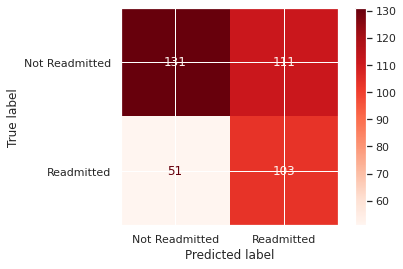

In [ ]:
# SVC
best_model_svc_ds = SVC(C=10, class_weight='balanced', gamma=0.001, kernel='rbf', probability=True)
best_model_svc_ds.fit(X_train_ds, y_train_ds)
print_model_performances(best_model_svc_ds, X_train_ds, y_train_ds, X_test, y_test)


  ***Scores obtained on train and test sets with best model***  

f1          train 0.669   test 0.559
recall      train 0.672   test 0.682
precision   train 0.666   test 0.473
accuracy    train 0.667   test 0.581

  ***Classification report on test set***  

                precision    recall  f1-score   support

Not Readmitted       0.72      0.52      0.60       242
    Readmitted       0.47      0.68      0.56       154

      accuracy                           0.58       396
     macro avg       0.60      0.60      0.58       396
  weighted avg       0.62      0.58      0.58       396


  ***Confusion matrix on test set***  



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0

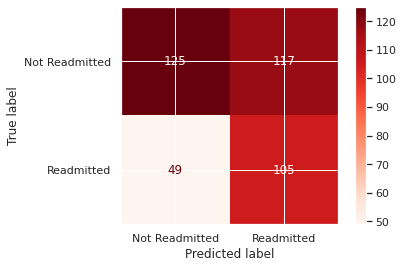

In [ ]:
# Logistic Regression
best_model_lr_ds = LogisticRegression(C=0.1, class_weight='balanced', max_iter=500, penalty='l2')
best_model_lr_ds.fit(X_train_ds, y_train_ds)
print_model_performances(best_model_lr_ds, X_train_ds, y_train_ds, X_test, y_test)

#### Voting Classifier


  ***Scores obtained on train and test sets with best model***  

f1          train 0.644   test 0.560
recall      train 0.693   test 0.636
precision   train 0.602   test 0.500
accuracy    train 0.703   test 0.611

  ***Classification report on test set***  

                precision    recall  f1-score   support

Not Readmitted       0.72      0.60      0.65       242
    Readmitted       0.50      0.64      0.56       154

      accuracy                           0.61       396
     macro avg       0.61      0.62      0.61       396
  weighted avg       0.63      0.61      0.62       396


  ***Confusion matrix on test set***  



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)



  ***Scores obtained on train and test sets with best model***  

f1          train 0.657   test 0.545
recall      train 0.615   test 0.545
precision   train 0.705   test 0.545
accuracy    train 0.751   test 0.646

  ***Classification report on test set***  

                precision    recall  f1-score   support

Not Readmitted       0.71      0.71      0.71       242
    Readmitted       0.55      0.55      0.55       154

      accuracy                           0.65       396
     macro avg       0.63      0.63      0.63       396
  weighted avg       0.65      0.65      0.65       396


  ***Confusion matrix on test set***  



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


0

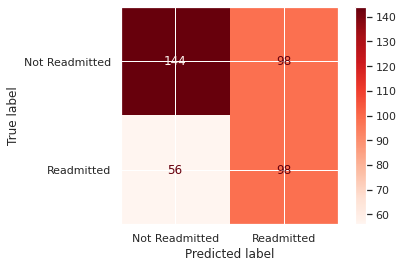

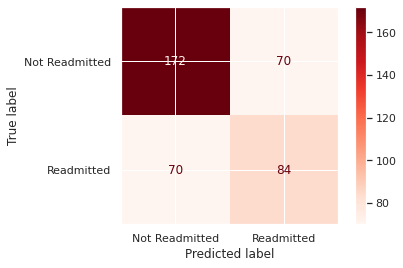

In [ ]:
from sklearn.ensemble import VotingClassifier

# Voting clf hard (vote among predicted classes)
best_model_rf = RandomForestClassifier(n_estimators=20, criterion='entropy', max_depth=4, max_features=None, class_weight='balanced', min_samples_split=3, min_samples_leaf=5)
best_model_svc = SVC(C=10, class_weight='balanced', gamma=0.001, kernel='rbf', probability=True)
best_model_lr = LogisticRegression(C=0.1, class_weight='balanced', max_iter=500, penalty='l2')

voting_clf_hard = VotingClassifier(estimators=[('rf', best_model_rf), ('svc', best_model_svc), ('lr', best_model_lr)], voting='hard')
voting_clf_hard.fit(X_train, y_train)

print_model_performances(voting_clf_hard, X_train, y_train, X_test, y_test)

# Voting clf soft (vote among predicted probabilities)
best_model_rf = RandomForestClassifier(n_estimators=20, criterion='entropy', max_depth=4, max_features=None, class_weight='balanced', min_samples_split=3, min_samples_leaf=5)
best_model_svc = SVC(C=10, class_weight='balanced', gamma=0.001, kernel='rbf', probability=True)
best_model_lr = LogisticRegression(C=0.1, class_weight='balanced', max_iter=500, penalty='l2')

voting_clf_soft = VotingClassifier(estimators=[('rf', best_model_rf), ('svc', best_model_svc), ('lr', best_model_lr)], voting='soft')
voting_clf_soft.fit(X_train, y_train)

print_model_performances(voting_clf_soft, X_train, y_train, X_test, y_test)

### Model comparison

#### ROC curve

In [ ]:
def roc(model, X_test, y_test):

    y_pred = model.predict(X_test)

    y_probs = model.predict_proba(X_test) # predict_proba gives the probabilities for the target 

    fpr, tpr, thresholds1 = roc_curve(y_test, y_probs[:,1])

    auc = roc_auc_score(y_test, y_probs[:,1])

    return (fpr, tpr, auc)

In [ ]:
# Decision Tree
fpr_tree, tpr_tree, auc_tree = roc(best_model_tree_id, X_test, y_test)

# Random Forest
fpr_rf, tpr_rf, auc_rf = roc(best_model_rf_id, X_test, y_test)
fpr_rf_20, tpr_rf_20, auc_rf_20 = roc(best_model_rf_id_20, X_test_rf_20, y_test)
fpr_rf_os, tpr_rf_os, auc_rf_os = roc(best_model_rf_os, X_test, y_test)
fpr_rf_ds, tpr_rf_ds, auc_rf_ds = roc(best_model_rf_ds, X_test, y_test)

# Adaboost
fpr_adb, tpr_adb, auc_adb = roc(best_model_adb_id, X_test, y_test)

# XGBoost
fpr_xgb, tpr_xgb, auc_xgb = roc(best_model_xgb_id, X_test, y_test)

# KNN
fpr_knn, tpr_knn, auc_knn = roc(best_model_knn_id, X_test, y_test)

# Logistic Regression
fpr_lr, tpr_lr, auc_lr = roc(best_model_lr_id, X_test, y_test)
fpr_lr_20, tpr_lr_20, auc_lr_20 = roc(best_model_lr_id_20, X_test_lr_20, y_test)
fpr_lr_os, tpr_lr_os, auc_lr_os = roc(best_model_lr_os, X_test, y_test)
fpr_lr_ds, tpr_lr_ds, auc_lr_ds = roc(best_model_lr_ds, X_test, y_test)

# SVM
fpr_svc, tpr_svc, auc_svc = roc(best_model_svc_id, X_test, y_test)
fpr_svc_20, tpr_svc_20, auc_svc_20 = roc(best_model_svc_id_20, X_test_svc_20, y_test)
fpr_svc_os, tpr_svc_os, auc_svc_os = roc(best_model_svc_os, X_test, y_test)
fpr_svc_ds, tpr_svc_ds, auc_svc_ds = roc(best_model_svc_ds, X_test, y_test)

# Multi-layer Perceptron
fpr_mlp, tpr_mlp, auc_mlp = roc(best_model_mlp_id, X_test, y_test)

# Naive Bayes
fpr_nb, tpr_nb, auc_nb = roc(best_model_nb_id, X_test, y_test)

# Voting Classifier
fpr_vclfs, tpr_vclfs, auc_vclfs = roc(voting_clf_soft, X_test, y_test)

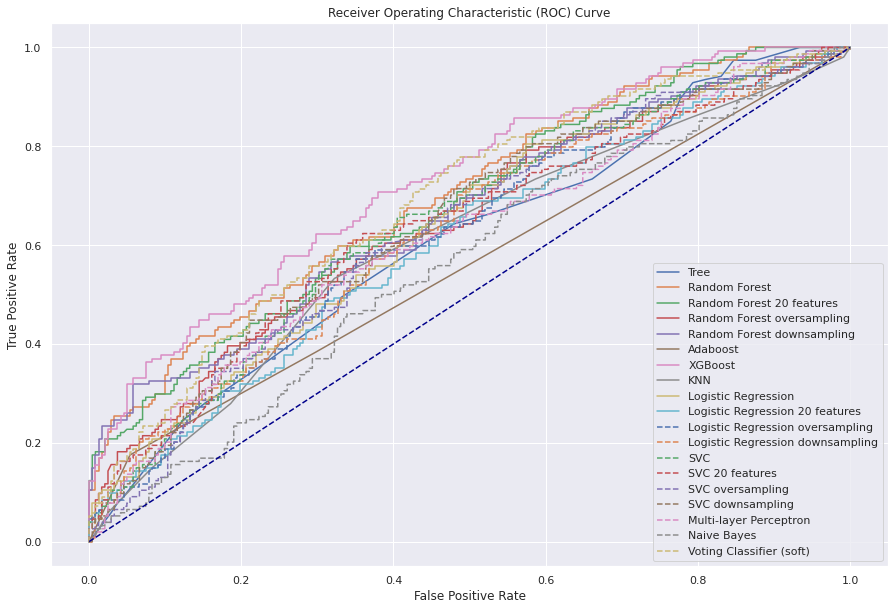

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(fpr_tree, tpr_tree, label= "Tree")
plt.plot(fpr_rf, tpr_rf, label= "Random Forest")
plt.plot(fpr_rf_20, tpr_rf_20, label= "Random Forest 20 features")
plt.plot(fpr_rf_os, tpr_rf_os, label= "Random Forest oversampling")
plt.plot(fpr_rf_ds, tpr_rf_ds, label= "Random Forest downsampling")
plt.plot(fpr_adb, tpr_adb, label= "Adaboost")
plt.plot(fpr_xgb, tpr_xgb, label= "XGBoost")
plt.plot(fpr_knn, tpr_knn, label= "KNN")
plt.plot(fpr_lr, tpr_lr, label= "Logistic Regression")
plt.plot(fpr_lr_20, tpr_lr_20, label= "Logistic Regression 20 features")
plt.plot(fpr_lr_os, tpr_lr_os, label= "Logistic Regression oversampling", linestyle= '--')
plt.plot(fpr_lr_ds, tpr_lr_ds, label= "Logistic Regression downsampling", linestyle= '--')
plt.plot(fpr_svc, tpr_svc, label= "SVC", linestyle= '--')
plt.plot(fpr_svc_20, tpr_svc_20, label= "SVC 20 features", linestyle= '--')
plt.plot(fpr_svc_os, tpr_svc_os, label= "SVC oversampling", linestyle= '--')
plt.plot(fpr_svc_ds, tpr_svc_ds, label= "SVC downsampling", linestyle= '--')
plt.plot(fpr_mlp, tpr_mlp, label= "Multi-layer Perceptron", linestyle= '--')
plt.plot(fpr_nb, tpr_nb, label= "Naive Bayes", linestyle= '--')
plt.plot(fpr_vclfs, tpr_vclfs, label= "Voting Classifier (soft)", linestyle= '--')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [ ]:
def prec_rec_curve(model, X_test, y_test):

    y_pred = model.predict(X_test)

    y_probs = model.predict_proba(X_test) # predict_proba gives the probabilities for the target

    precision, recall, thresholds1 = precision_recall_curve(y_test, y_probs[:,1])

    return (precision, recall)

In [ ]:
# Decision Tree
prec_tree, rec_tree = prec_rec_curve(best_model_tree_id, X_test, y_test)

# Random Forest
prec_rf, rec_rf = prec_rec_curve(best_model_rf_id, X_test, y_test)
prec_rf_20, rec_rf_20 = prec_rec_curve(best_model_rf_id_20, X_test_rf_20, y_test)
prec_rf_os, rec_rf_os = prec_rec_curve(best_model_rf_os, X_test, y_test)
prec_rf_ds, rec_rf_ds = prec_rec_curve(best_model_rf_ds, X_test, y_test)

# Adaboost
prec_adb, rec_adb = prec_rec_curve(best_model_adb_id, X_test, y_test)

# XGBoost
prec_xgb, rec_xgb = prec_rec_curve(best_model_xgb_id, X_test, y_test)

# KNN
prec_knn, rec_knn = prec_rec_curve(best_model_knn_id, X_test, y_test)

# Logistic Regression
prec_lr, rec_lr = prec_rec_curve(best_model_lr_id, X_test, y_test)
prec_lr_20, rec_lr_20 = prec_rec_curve(best_model_lr_id_20, X_test_lr_20, y_test)
prec_lr_os, rec_lr_os = prec_rec_curve(best_model_lr_os, X_test, y_test)
prec_lr_ds, rec_lr_ds = prec_rec_curve(best_model_lr_ds, X_test, y_test)

# SVM
prec_svc, rec_svc = prec_rec_curve(best_model_svc_id, X_test, y_test)
prec_svc_20, rec_svc_20 = prec_rec_curve(best_model_svc_id_20, X_test_svc_20, y_test)
prec_svc_os, rec_svc_os = prec_rec_curve(best_model_svc_os, X_test, y_test)
prec_svc_ds, rec_svc_ds = prec_rec_curve(best_model_svc_ds, X_test, y_test)

# Multi-layer Perceptron
prec_mlp, rec_mlp = prec_rec_curve(best_model_mlp_id, X_test, y_test)

# Naive Bayes
prec_nb, rec_nb = prec_rec_curve(best_model_nb_id, X_test, y_test)

# Voting Classifier 
prec_vclfs, rec_vclfs = prec_rec_curve(voting_clf_soft, X_test, y_test)

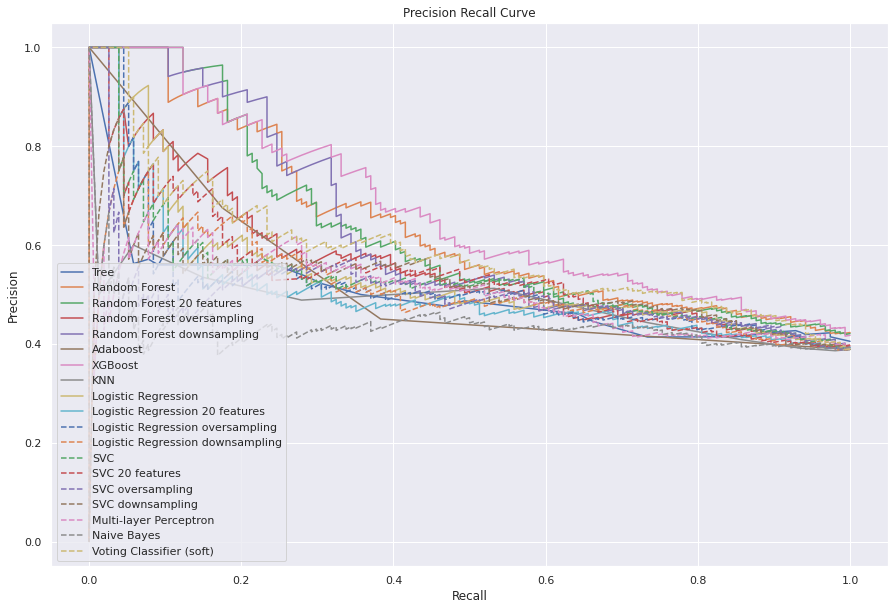

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(rec_tree, prec_tree, label= "Tree")
plt.plot(rec_rf, prec_rf, label= "Random Forest")
plt.plot(rec_rf_20, prec_rf_20, label= "Random Forest 20 features")
plt.plot(rec_rf_os, prec_rf_os, label= "Random Forest oversampling")
plt.plot(rec_rf_ds, prec_rf_ds, label= "Random Forest downsampling")
plt.plot(rec_adb, prec_adb, label= "Adaboost")
plt.plot(rec_xgb, prec_xgb, label= "XGBoost")
plt.plot(rec_knn, prec_knn, label= "KNN")
plt.plot(rec_lr, prec_lr, label= "Logistic Regression")
plt.plot(rec_lr_20, prec_lr_20, label= "Logistic Regression 20 features")
plt.plot(rec_lr_os, prec_lr_os, label= "Logistic Regression oversampling", linestyle= '--')
plt.plot(rec_lr_ds, prec_lr_ds, label= "Logistic Regression downsampling", linestyle= '--')
plt.plot(rec_svc, prec_svc, label= "SVC", linestyle= '--')
plt.plot(rec_svc_20, prec_svc_20, label= "SVC 20 features", linestyle= '--')
plt.plot(rec_svc_os, prec_svc_os, label= "SVC oversampling", linestyle= '--')
plt.plot(rec_svc_ds, prec_svc_ds, label= "SVC downsampling", linestyle= '--')
plt.plot(rec_mlp, prec_mlp, label= "Multi-layer Perceptron", linestyle= '--')
plt.plot(rec_nb, prec_nb, label= "Naive Bayes", linestyle= '--')
plt.plot(rec_vclfs, prec_vclfs, label= "Voting Classifier (soft)", linestyle= '--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend()
plt.show()

# OLD

(1584, 15)

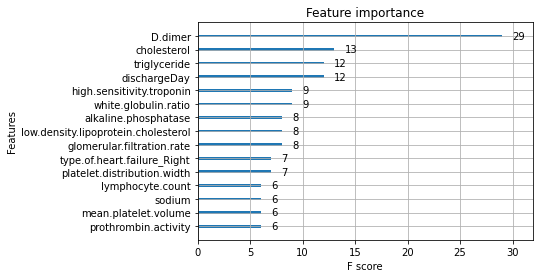

In [ ]:
labels = plot_importance(best_model_xgboost, max_num_features=15, importance_type='weight').get_yticklabels()

most_important_features = []
for lab in labels:
  most_important_features.append(lab.get_text())


X_train_imp_features = X_train[most_important_features]
X_test_imp_features = X_test[most_important_features]

X_train_imp_features.shape